# Analysis of Kr data. Run 2980

In [55]:
from __future__ import print_function
import tables as tb
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import copy
import glob
import os

import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm
import Core.sensorFunctions as sns
import Core.fitFunctions as fit
import Core.tblFunctions as tbl

import Database.loadDB as DB

matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8) # Bigger plots
%matplotlib inline
%load_ext autoreload
%autoreload 2

print("This notebook has been run last on {} at {}.".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
This notebook has been run last on 28/11/2016 at 16:17:22.


In [139]:
sipmdf = DB.DataSiPM()

In [15]:
folder = "/Users/Gonzalo/github/IC/data/DATA/run_2980/"
pmaps = []
max_evt = 10000
nevt = 0
for filename in glob.glob(folder+"*.h5"):
    print(filename)
    with tb.open_file(filename) as h5f:
        pmaptbl = h5f.root.PMAPS.PMaps
        pmaps_ = [tbl.read_pmap(pmaptbl, ievt) for ievt in range(tbl.get_nofevents(pmaptbl, "event"))]
        pmaps.extend(pmaps_)
        nevt += len(pmaps_)
        if nevt > max_evt:
            break
print("Total number of pmaps:", len(pmaps))
pmaps = np.array(pmaps, dtype=object)

## Some checks about the number of peaks

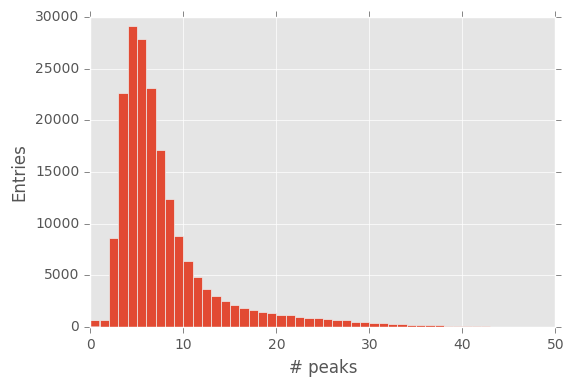

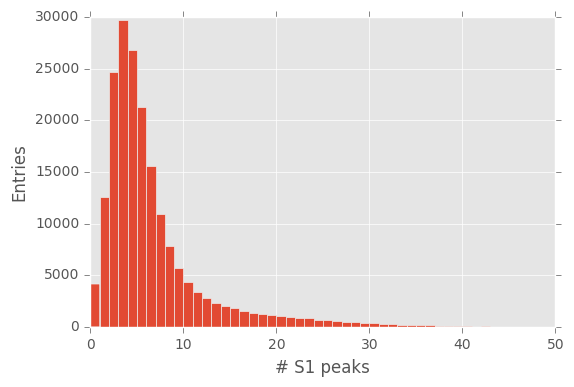

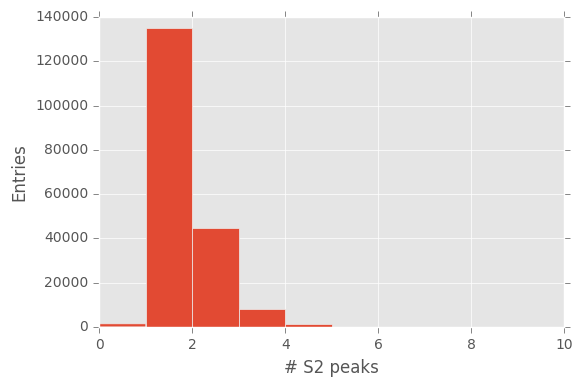

In [151]:
h = plt.hist([len(pmap.peaks) for pmap in pmaps], 50, range=(0,50))
plt.xlabel("# peaks")
plt.ylabel("Entries")

plt.figure()
h = plt.hist([len(pmap.get("S1")) for pmap in pmaps], 50, range=(0,50))
plt.xlabel("# S1 peaks")
plt.ylabel("Entries")

plt.figure()
h = plt.hist([len(pmap.get("S2")) for pmap in pmaps], 10, range=(0,10))
plt.xlabel("# S2 peaks")
plt.ylabel("Entries")

In [154]:
h[0][1]*100./h[0].sum()

70.808973773092333

#### The number of S1s is huge. But the number of S2s is reasonable. Placing a cut to select only those events with exactly one S2 and some S1 means reducing the sample to 70%

In [166]:
selection = np.array([len(pmap.get("S1"))>0 and len(pmap.get("S2"))==1 for pmap in pmaps], dtype=bool)

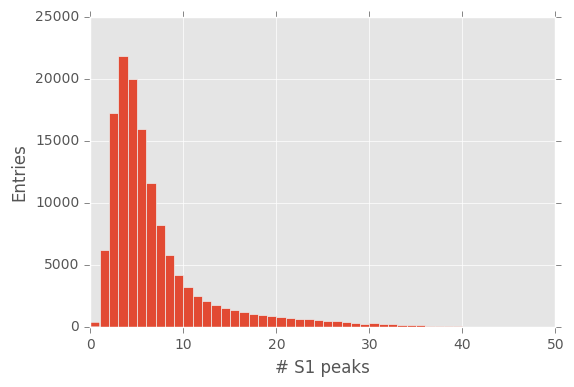

In [167]:
plt.figure()
h = plt.hist([len(pmap.get("S1")) for pmap in pmaps[selection]], 50, range=(0,50))
plt.xlabel("# S1 peaks")
plt.ylabel("Entries")

#### The number of S1s has not been reduced much after this selection. Lets look at the integral of the peaks.

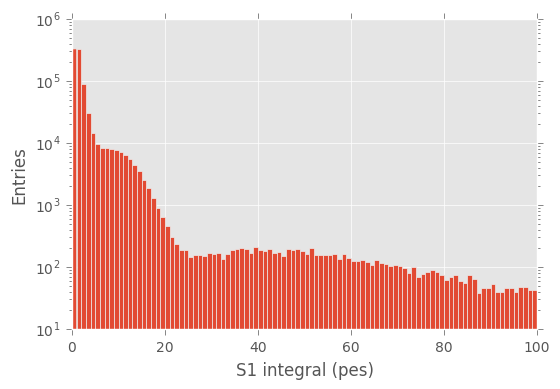

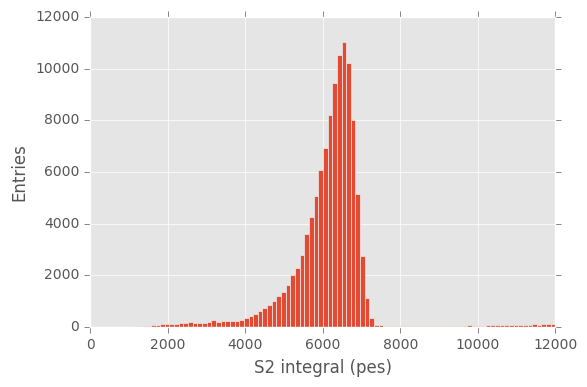

In [168]:
h = plt.hist([peak.cathode_integral for pmap in pmaps[selection] for peak in pmap.get("S1")], 100, range=(0, 100))
plt.xlabel("S1 integral (pes)")
plt.ylabel("Entries")
plt.yscale("log")

plt.figure()
h = plt.hist([peak.cathode_integral for pmap in pmaps[selection] for peak in pmap.get("S2")], 100, range=(0, 12000))
plt.xlabel("S2 integral (pes)")
plt.ylabel("Entries")
#plt.yscale("log")
pass

#### There is clearly somrething wrong with the integral of the S1 peaks. S2s, however, look pretty good. We only need to place a soft cut to pick up the Kr peak alone.

In [169]:
selection = np.array([len(pmap.get("S1"))>0 and len(pmap.get("S2"))==1 and 4000 < pmap.get("S2")[0].cathode_integral < 7800 for pmap in pmaps], dtype=bool)

#### The width of the S2 peaks is also a important feature

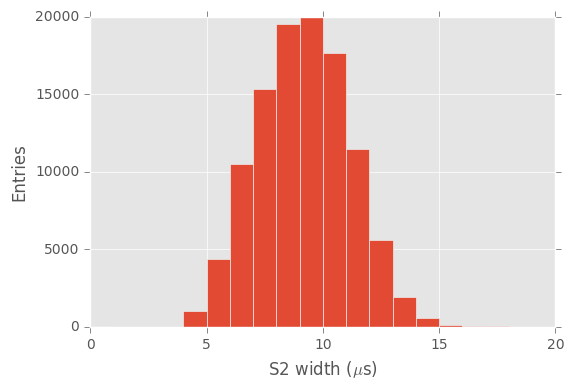

In [172]:
h = plt.hist([peak.width for pmap in pmaps[selection] for peak in pmap.get("S2")], 20, range=(0,20))
plt.xlabel("S2 width ($\mu$s)")
plt.ylabel("Entries")
pass

#### There are some events with wrong width. A cut at 15 $\mu$s is enough.

In [175]:
selection = np.array([len(pmap.get("S1"))>0 and len(pmap.get("S2"))==1 and 4000 < pmap.get("S2")[0].cathode_integral < 7800 and pmap.get("S2")[0].width<15 for pmap in pmaps], dtype=bool)

#### The S1 peak with maximum height may have something to say...

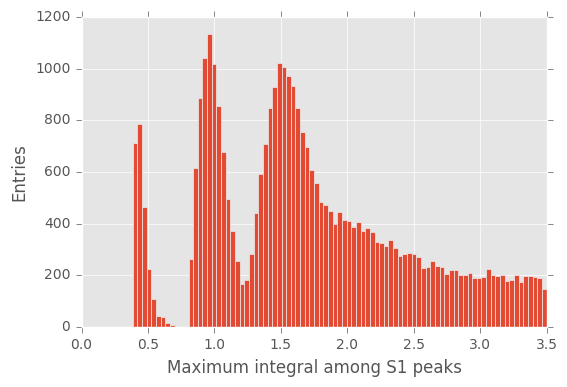

In [178]:
h = plt.hist([max(peak.cathode_integral for peak in pmap.get("S1")) for pmap in pmaps[selection]], 100, range=(0,3.5) )
plt.xlabel("Maximum integral among S1 peaks")
plt.ylabel("Entries")
pass

#### There is a clear structure here but it seems that the *real* S1s are those of the peaks in the middle

In [179]:
selection = np.array([len(pmap.get("S1"))>0 and len(pmap.get("S2"))==1 and 4000 < pmap.get("S2")[0].cathode_integral < 7800 and pmap.get("S2")[0].width<15 and 0.8 < max(peak.cathode_integral for peak in pmap.get("S1")) < 1.25 for pmap in pmaps], dtype=bool)

#### Let's see where are the S1s

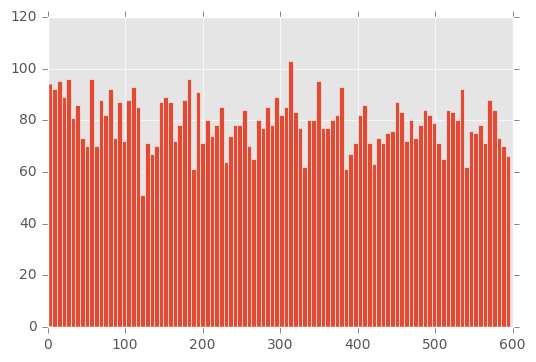

In [183]:
h = plt.hist([pmap.get("S1")[np.argmax([peak.cathode_integral for peak in pmap.get("S1")])].peakmax[0] for pmap in pmaps[selection]], 100)

#### Quite uniform. Now the S2s

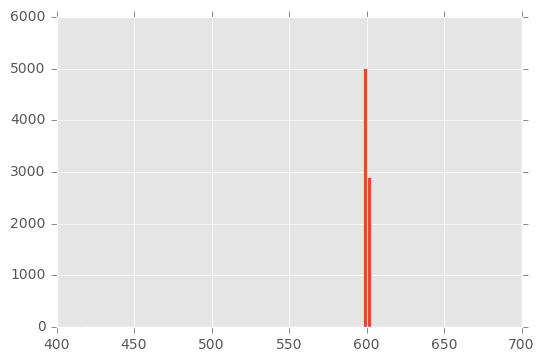

In [184]:
h = plt.hist([pmap.get("S2")[0].peakmax[0] for pmap in pmaps[selection]], 100)

#### The S2s are always at 600 $\mu$s. A feature caused by the trigger.

# Raw spectrum fitted to a gaussian

fit values: [ 243175.71257743    6380.15275679     430.47528734]
FWHM resolution: 15.8556850251% => 2.06024144292% @ Qbb


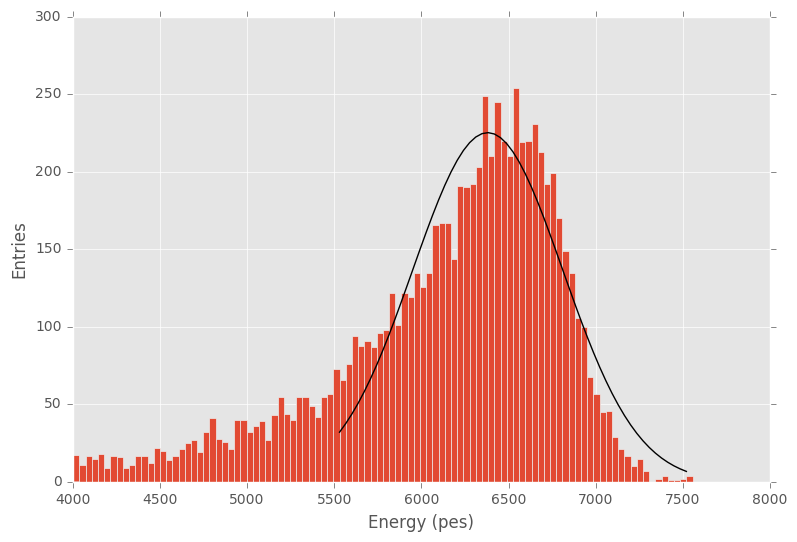

fit values: [ 19650.72947918   6662.35650843    244.92218186]
FWHM resolution: 8.63909228878% => 1.12253844185% @ Qbb


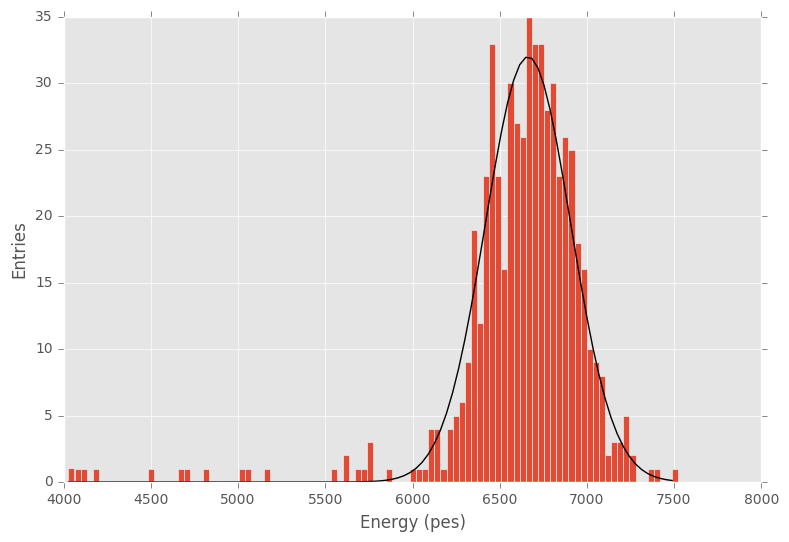

In [295]:
E = np.array([pmap.E for pmap in pmaps[selection]])
h = plt.hist(E, 100)
x, y = h[1][:-1], h[0]
x, y = x[x>5500], y[x>5500]
f, v, e = fit.fit("gauss", x, y, (1e3, 6500., 300.))
plt.plot(x, f(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
plt.gcf().set_size_inches(9,6)
print("fit values:", v)
print("FWHM resolution: {}% => {}% @ Qbb".format(235.*v[2]/v[1], 235.*v[2]/v[1]*(41.5/2458.)**0.5))

plt.show()
plt.figure()
E = np.array([pmap.E for pmap in pmaps[selection] if pmap.r < 50.])
h = plt.hist(E, 100)
x, y = h[1][:-1], h[0]
f, v, e = fit.fit("gauss", x, y, (1e3, 6500., 300.))
plt.plot(x, f(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
plt.gcf().set_size_inches(9,6)
print("fit values:", v)
print("FWHM resolution: {}% => {}% @ Qbb".format(235.*v[2]/v[1], 235.*v[2]/v[1]*(41.5/2458.)**0.5))

## Let's set the t0 and z coordinates for these events

In [188]:
for pmap in pmaps[selection]:
    S1s = pmap.get("S1")
    S2 = pmap.get("S2")[0]
    largestS1 = S1s[np.argmax([peak.cathode_integral for peak in S1s])]
    pmap.t0 = largestS1.peakmax[0]
    pmap.z = S2.peakmax[0] - pmap.t0
    pmap.E = S2.cathode_integral

### A plot of the distribution of the events in z

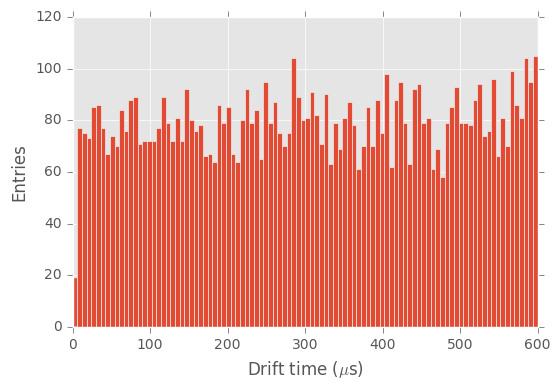

In [187]:
h = plt.hist([pmap.z for pmap in pmaps[selection]], 100, range=(0,600))
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("Entries")

#### As expected. Let's see how the energy drops in z due to attachment

fit values: [  6.24577726e+03  -8.14994024e+10]


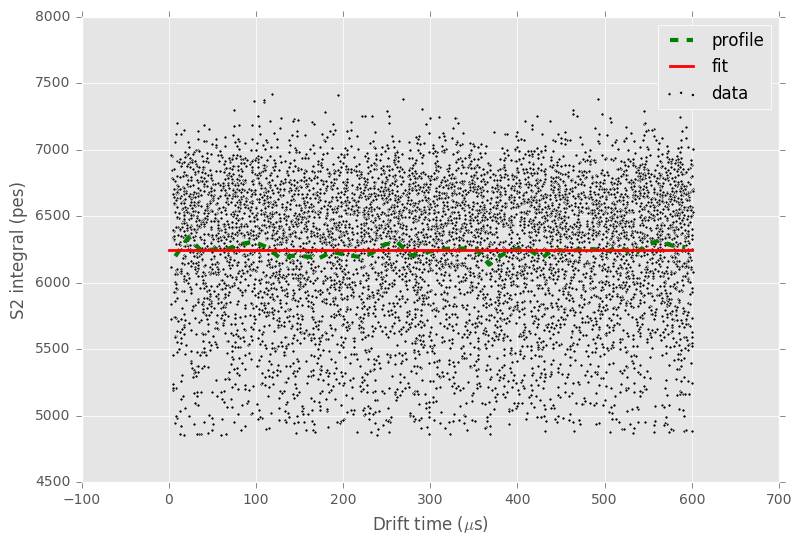

In [280]:
z, E = map(np.array, zip(*[(pmap.z, pmap.E) for pmap in pmaps[selection]]))
z, E = z[abs(E-np.mean(E))<np.std(E)*2], E[abs(E-np.mean(E))<np.std(E)*2]
zp, Ep, Eerr = fit.profile(z, E, 40, (0, 600))
f, v, e = fit.fit("expo", zp, Ep, (6500., -1e4), sigma=Eerr)
plt.scatter(z, E, marker=".", facecolor="k", label="data")
plt.plot(zp, Ep, "g--", linewidth=3, label="profile")
x = np.linspace(0., 600., 1000)
plt.plot(x, f(x), "r-", label="fit", linewidth=2)
#plt.ylim((0, plt.ylim()[1]))
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("S2 integral (pes)")
plt.legend()
plt.gcf().set_size_inches(9,6)

print("fit values:", v)

#### No effect, let's limit to the center

In [281]:
def baricenter(pmap, sipmdf, thrs=0.25):
    anode = np.concatenate([peak.anode for peak in pmap])
    q = np.nansum(anode, axis=0)
    selection = q > np.max(q) * thrs
    q = q[selection]
    if q.sum() < 1.:
        return 1e4, 1e4
    x = np.average(sipmdf["X"].values[selection], weights=q)
    y = np.average(sipmdf["Y"].values[selection], weights=q)
    return x, y

def centered(pmap, sipmdf, rmax=100., thrs=0.25):
    x, y = baricenter(pmap, sipmdf, thrs)
    return x**2 + y**2 < rmax**2

fit values: [   6693.80604167 -176720.41390129]


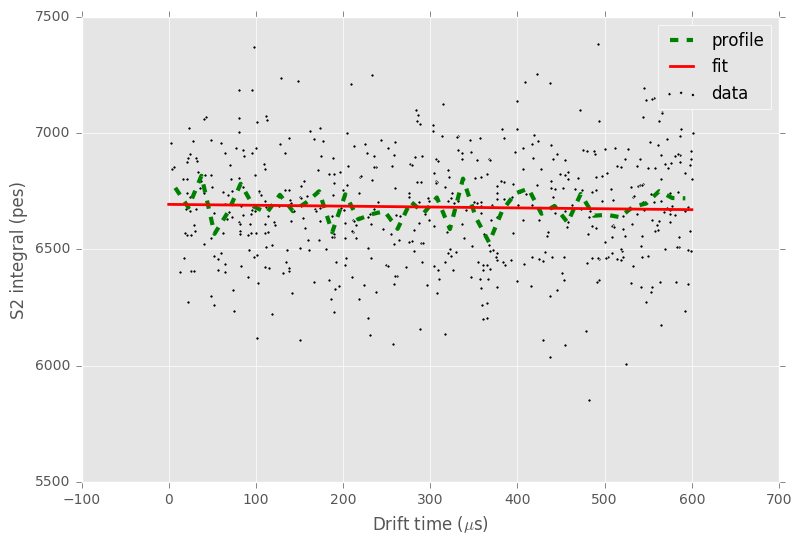

In [282]:
z, E = map(np.array, zip(*[(pmap.z, pmap.E) for pmap in pmaps[selection] if centered(pmap, sipmdf, 50., 0.5)]))
z, E = z[abs(E-np.mean(E))<np.std(E)*2], E[abs(E-np.mean(E))<np.std(E)*2]
zp, Ep, Eerr = fit.profile(z, E, 40, (0, 600))
f, v, e = fit.fit("expo", zp, Ep, (6500., -1e4), sigma=Eerr)
plt.scatter(z, E, marker=".", facecolor="k", label="data")
plt.plot(zp, Ep, "g--", linewidth=3, label="profile")
x = np.linspace(0., 600., 1000)
plt.plot(x, f(x), "r-", label="fit", linewidth=2)
#plt.ylim((0, plt.ylim()[1]))
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("S2 integral (pes)")
plt.legend()
print("fit values:", v)
plt.gcf().set_size_inches(9,6)

att_func = copy.copy(f)
att_corr = lambda x: att_func(0.)/att_func(x)

#### A bit more, but the attachment is still much smaller than expected. The effect on resolution will also be small.

fit values: [ 246201.40927217    6387.40195806     436.69618191]
FWHM resolution: 16.0665640619% => 2.08764244958% @ Qbb


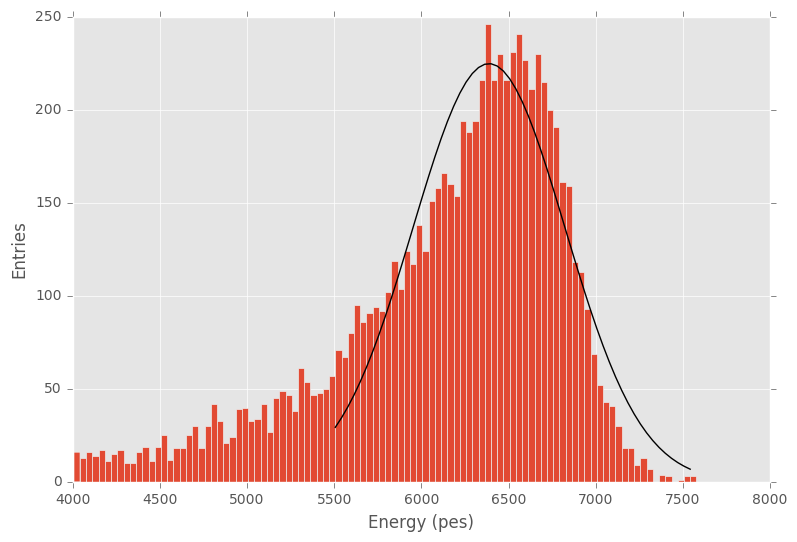

fit values: [ 19687.71436775   6673.60194701    246.97385049]
FWHM resolution: 8.69678103748% => 1.13003434951% @ Qbb


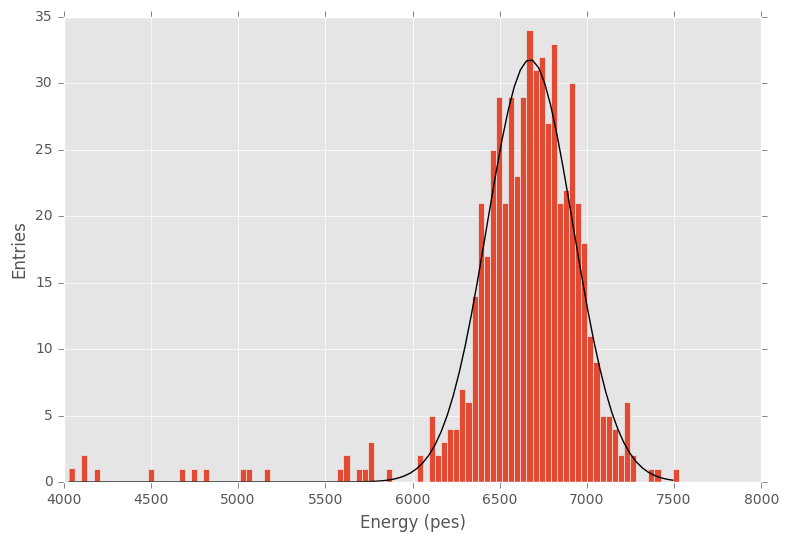

In [296]:
E = np.array([pmap.E * att_corr(pmap.z) for pmap in pmaps[selection]])
h = plt.hist(E, 100)
x, y = h[1][:-1], h[0]
x, y = x[x>5500], y[x>5500]
f, v, e = fit.fit("gauss", x, y, (1e3, 6500., 300.))
plt.plot(x, f(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
plt.gcf().set_size_inches(9,6)
print("fit values:", v)
print("FWHM resolution: {}% => {}% @ Qbb".format(235.*v[2]/v[1], 235.*v[2]/v[1]*(41.5/2458.)**0.5))
plt.show()

plt.figure()
E = np.array([pmap.E * att_corr(pmap.z) for pmap in pmaps[selection] if pmap.r < 50.])
h = plt.hist(E, 100)
x, y = h[1][:-1], h[0]
f, v, e = fit.fit("gauss", x, y, (1e3, 6500., 300.))
plt.plot(x, f(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
plt.gcf().set_size_inches(9,6)
print("fit values:", v)
print("FWHM resolution: {}% => {}% @ Qbb".format(235.*v[2]/v[1], 235.*v[2]/v[1]*(41.5/2458.)**0.5))

## Let's move to geometrical effects

In [268]:
for pmap in pmaps[selection]:
    pmap.x, pmap.y = baricenter(pmap, sipmdf, 0.5)
    pmap.r = (pmap.x**2 + pmap.y**2)**0.5

#### First, the XY distribution of the events

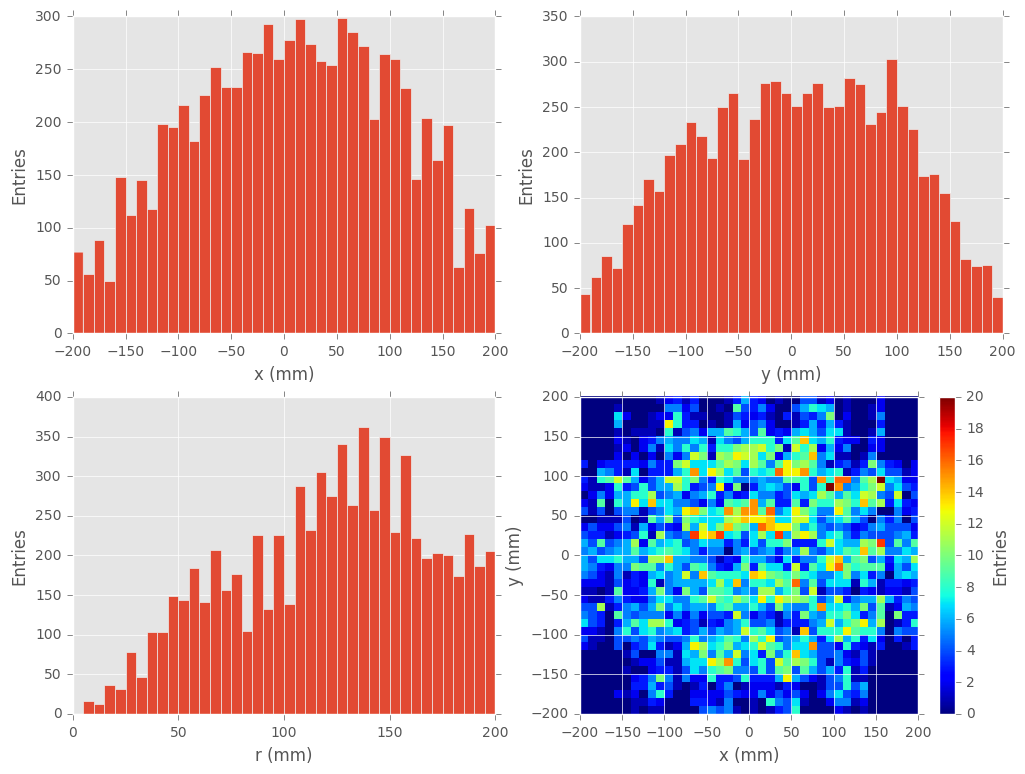

In [269]:
x, y, r = map(np.array, zip(*[(pmap.x, pmap.y, pmap.r) for pmap in pmaps[selection]]))

plt.subplot(2,2,1)
h = plt.hist(x, 40, range=(-200., 200.))
plt.xlabel("x (mm)")
plt.ylabel("Entries")

plt.subplot(2,2,2)
h = plt.hist(y, 40, range=(-200., 200.))
plt.xlabel("y (mm)")
plt.ylabel("Entries")

plt.subplot(2,2,3)
h = plt.hist(r, 40, range=(0., 200.))
plt.xlabel("r (mm)")
plt.ylabel("Entries")

plt.subplot(2,2,4)
h = plt.hist2d(x, y, 40, range=((-200., 200.), (-200., 200.)))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar().set_label("Entries")

plt.gcf().set_size_inches(12, 9)

#### It seems that there are some structures present, but let's say it is good enough. We are interested in energy vs r.

fit values: [  6.52659658e+03   4.05605702e+00  -4.68244647e-02]


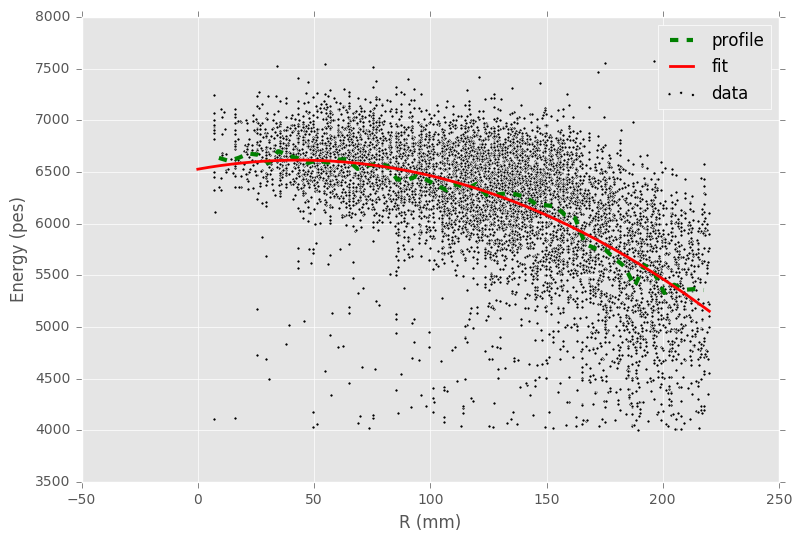

In [285]:
r, E = map(np.array, zip(*[(pmap.r, pmap.E * att_corr(pmap.z)) for pmap in pmaps[selection]]))
r, E = r[r<220.], E[r<220.]
rp, Ep, Ep_err = fit.profile(r, E, 50)

p = plt.scatter(r, E, marker=".", facecolors="k", label="data")
p = plt.plot(rp, Ep, "g--", linewidth=3, label="profile")

f, v, e = fit.fit("polynom", r, E, (6000., -1e-2, -1e-4))
print("fit values:", v)
x = np.linspace(0., 220., 1000)
y = f(x)
plt.plot(x, y, "r-", linewidth=2, label="fit")
plt.xlabel("R (mm)")
plt.ylabel("Energy (pes)")
plt.legend()
plt.gcf().set_size_inches(9,6)

geo_func = copy.copy(f)
geo_corr = lambda x: geo_func(0.)/geo_func(x)

#### Huge effect on r. Lets see how is the spectrum is affected.

fit values: [  7.63074273e+05   6.56992982e+03   4.17397948e+02]
FWHM resolution: 14.9299186329% => 1.93995005943% @ Qbb


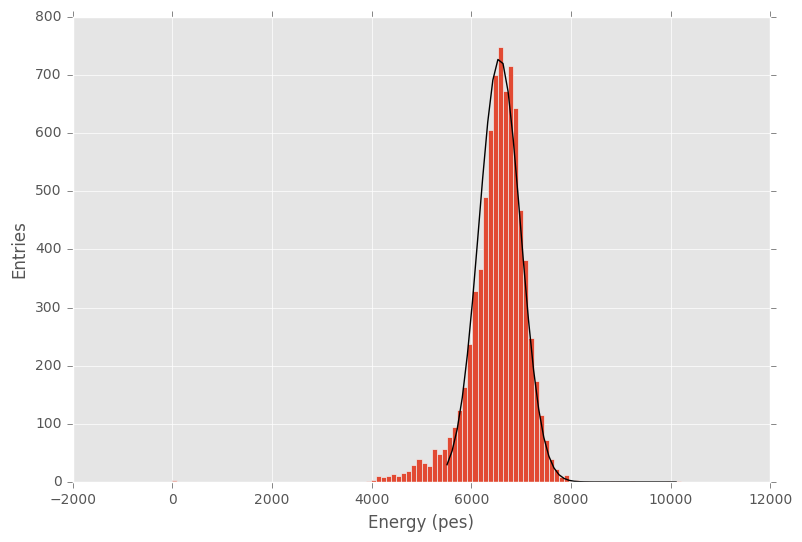

fit values: [ 19386.69484289   6590.59028482    243.1169933 ]
FWHM resolution: 8.66879762744% => 1.12639826687% @ Qbb


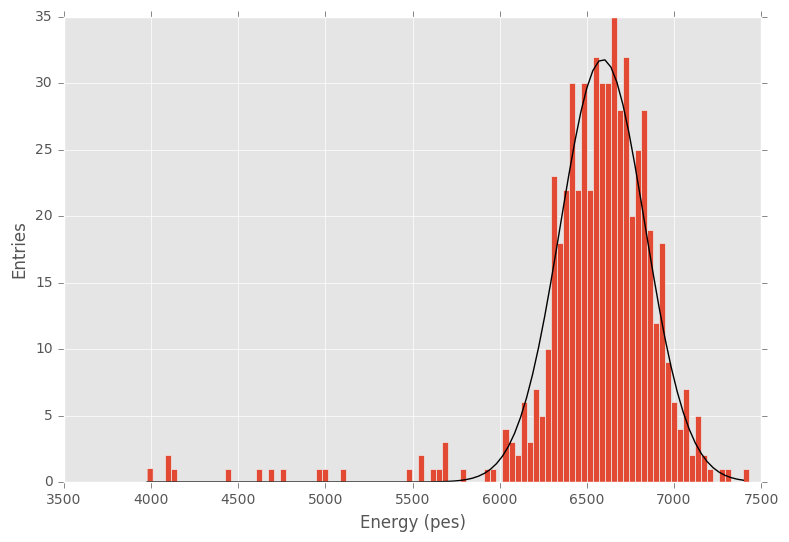

In [291]:
E = np.array([pmap.E * att_corr(pmap.z) * geo_corr(pmap.r) for pmap in pmaps[selection]])
h = plt.hist(E, 100)
x, y = h[1][:-1], h[0]
x, y = x[x>5500], y[x>5500]
f, v, e = fit.fit("gauss", x, y, (1e3, 6500., 300.))
plt.plot(x, f(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
plt.gcf().set_size_inches(9,6)
print("fit values:", v)
print("FWHM resolution: {}% => {}% @ Qbb".format(235.*v[2]/v[1], 235.*v[2]/v[1]*(41.5/2458.)**0.5))
plt.show()

plt.figure()
E = np.array([pmap.E * att_corr(pmap.z) * geo_corr(pmap.r) for pmap in pmaps[selection] if pmap.r < 50.])
h = plt.hist(E, 100)
x, y = h[1][:-1], h[0]
f, v, e = fit.fit("gauss", x, y, (1e3, 6500., 300.))
plt.plot(x, f(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
plt.gcf().set_size_inches(9,6)
print("fit values:", v)
print("FWHM resolution: {}% => {}% @ Qbb".format(235.*v[2]/v[1], 235.*v[2]/v[1]*(41.5/2458.)**0.5))

#### Funnily enough, it doesn't seem to improve energy resolution. This is caused by the large dispersion of the measured energy for large radii.

fit values: [  6.52679141e+03   4.81883526e-03  -4.47198825e-05]


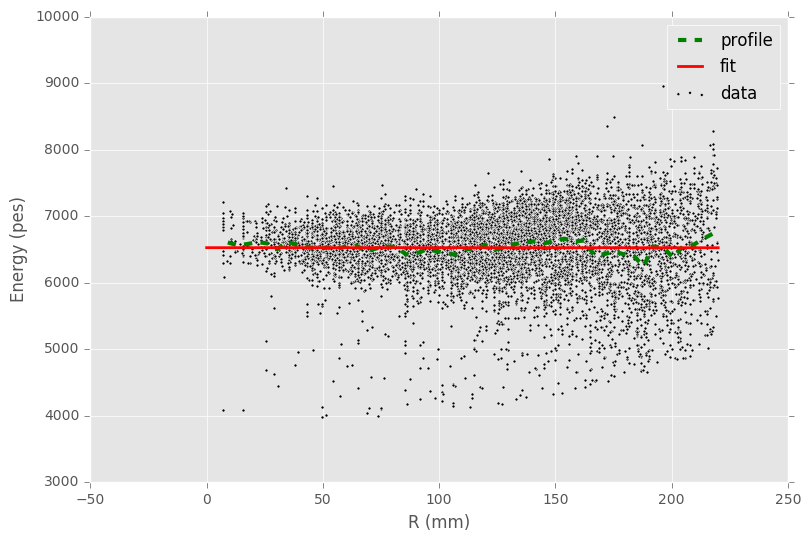

In [297]:
r, E = map(np.array, zip(*[(pmap.r, pmap.E * att_corr(pmap.z) * geo_corr(pmap.r)) for pmap in pmaps[selection]]))
r, E = r[r<220.], E[r<220.]
rp, Ep, Ep_err = fit.profile(r, E, 50)

p = plt.scatter(r, E, marker=".", facecolors="k", label="data")
p = plt.plot(rp, Ep, "g--", linewidth=3, label="profile")

f, v, e = fit.fit("polynom", r, E, (6000., -1e-2, -1e-4))
print("fit values:", v)
x = np.linspace(0., 220., 1000)
y = f(x)
plt.plot(x, y, "r-", linewidth=2, label="fit")
plt.xlabel("R (mm)")
plt.ylabel("Energy (pes)")
plt.legend()
plt.gcf().set_size_inches(9,6)

geo_func = copy.copy(f)
geo_corr = lambda x: geo_func(0.)/geo_func(x)

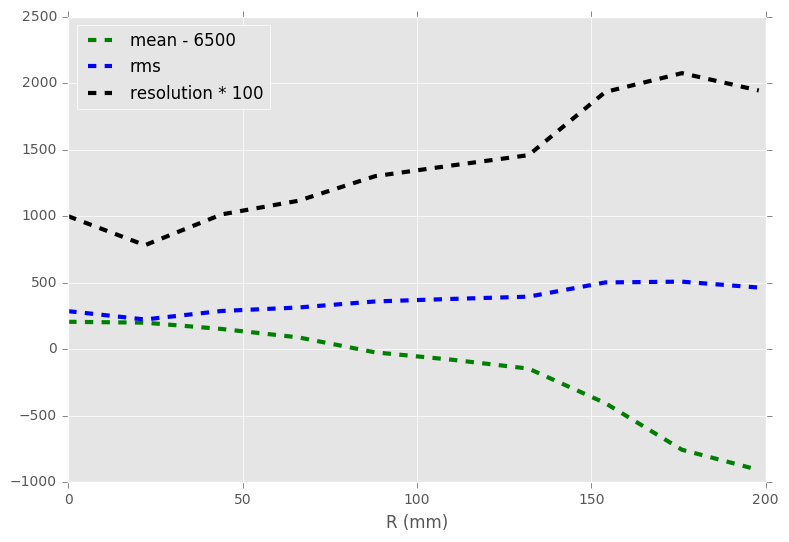

In [312]:
r, E = map(np.array, zip(*[(pmap.r, pmap.E * att_corr(pmap.z) * geo_corr(pmap.r)) for pmap in pmaps[selection]]))
r, E = r[r<220.], E[r<220.]

mean, rms, reso = [], [], []
for i in range(10):
    x, y = fit.projectionY(r, E, 50, (5000, 7500), (i*22., (i+1)*22.))
    f, v, e = fit.fit("gauss", x, y, (1000., 6500., 400.))
    mean.append(v[1] - 6500)
    rms.append(v[2])
    reso.append(235.*v[2]/v[1] * 100)

p = plt.plot(np.linspace(0, 220, 10, endpoint=False), mean, "g--", linewidth=3, label="mean - 6500")
p = plt.plot(np.linspace(0, 220, 10, endpoint=False), rms, "b--", linewidth=3, label="rms")
p = plt.plot(np.linspace(0, 220, 10, endpoint=False), reso, "k--", linewidth=3, label="resolution * 100")

plt.xlabel("R (mm)")
plt.legend(loc='upper left')
plt.gcf().set_size_inches(9,6)

#### This makes pretty clear that we are not getting better resolution because the standart deviation increases while the mean decreases.

In [124]:
def good(pmap):
    s1s = pmap.get("S1")
    s2s = pmap.get("S2")
    if len(s2s) != 1 or not (4000 < s2s[0].cathode_integral < 7700):
        return False
#    if len(s1s) == 0 or not (0.8 < max(p.cathode_integral for p in s1s) < 3.):
#    if len(s1s) == 0 or not (0.8 < max(p.cathode_integral for p in s1s) < 1.25):
    if len(s1s) == 0 or not (1.25 < max(p.cathode_integral for p in s1s) < 3.):
        return False
    if s2s[0].width > 15.:
        return False
    return True

In [64]:
pmaps = np.array(pmaps, dtype=object)

In [125]:
selection = np.array(map(good, pmaps))

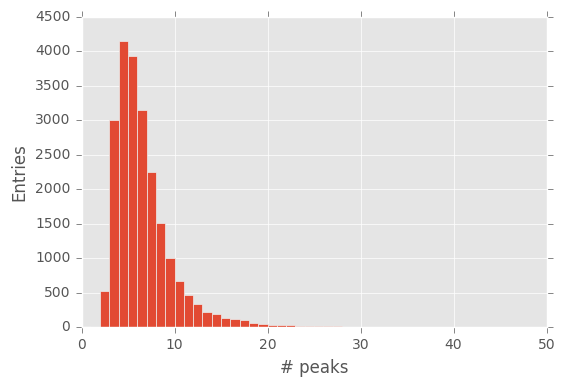

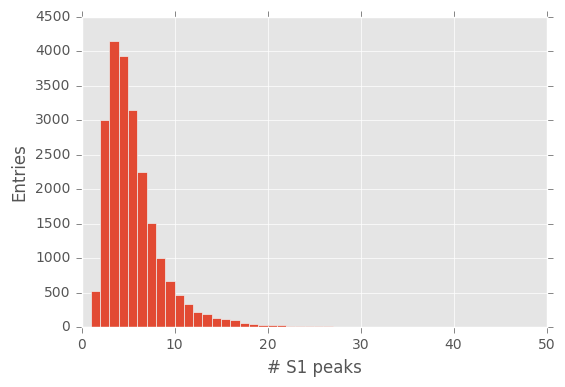

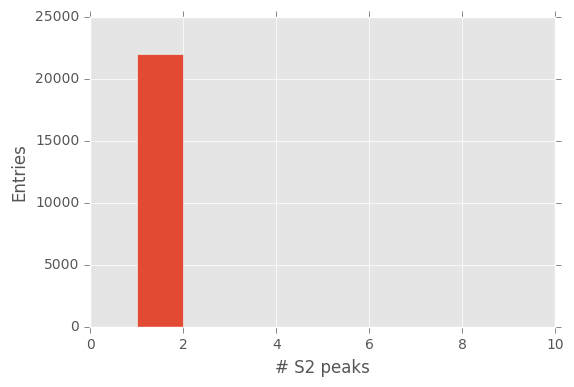

In [126]:
h = plt.hist([len(pmap.peaks) for pmap in pmaps[selection]], 50, range=(0,50))
plt.xlabel("# peaks")
plt.ylabel("Entries")

plt.figure()
h = plt.hist([len(pmap.get("S1")) for pmap in pmaps[selection]], 50, range=(0,50))
plt.xlabel("# S1 peaks")
plt.ylabel("Entries")

plt.figure()
h = plt.hist([len(pmap.get("S2")) for pmap in pmaps[selection]], 10, range=(0,10))
plt.xlabel("# S2 peaks")
plt.ylabel("Entries")

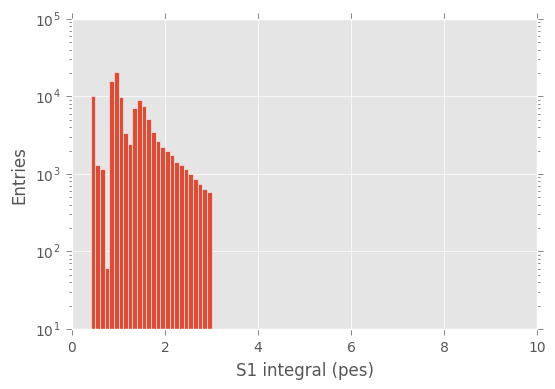

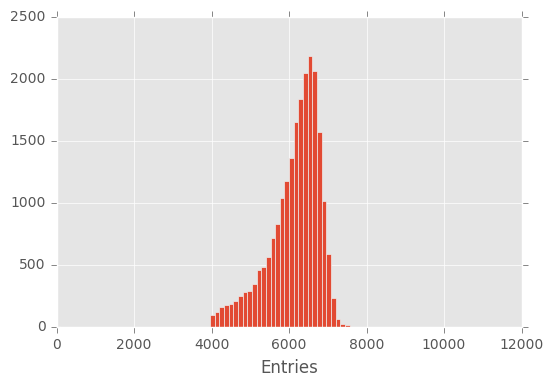

In [127]:
h = plt.hist([peak.cathode_integral for pmap in pmaps[selection] for peak in pmap.get("S1")], 100, range=(0, 10))
plt.xlabel("S1 integral (pes)")
plt.ylabel("Entries")
plt.yscale("log")

plt.figure()
h = plt.hist([peak.cathode_integral for pmap in pmaps[selection] for peak in pmap.get("S2")], 100, range=(0, 12000))
plt.xlabel("S2 integral (pes)")
plt.xlabel("Entries")
#plt.yscale("log")

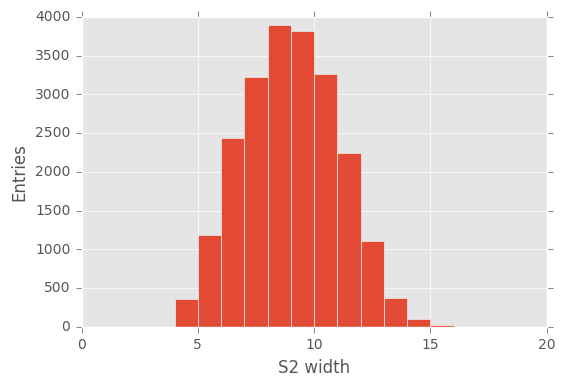

In [128]:
h = plt.hist([pmap.get("S2")[0].width for pmap in pmaps[selection]], 20, range=(0,20))
plt.xlabel("S2 width")
plt.ylabel("Entries")

(0, 20)

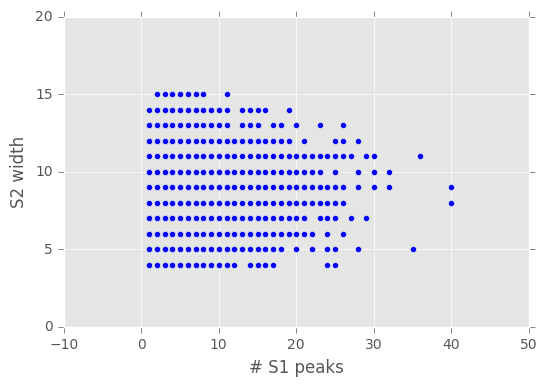

In [129]:
ns1, width = [], []
for pmap in pmaps[selection]:
    ns1.append( len(pmap.get("S1")) )
    width.append( pmap.get("S2")[0].width )
h = plt.scatter(ns1, width)
plt.xlabel("# S1 peaks")
plt.ylabel("S2 width")
plt.ylim((0,20))

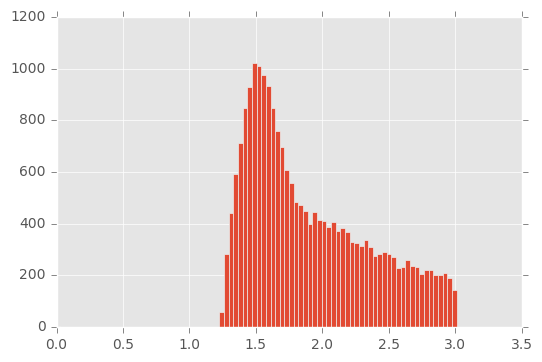

In [130]:
h = plt.hist([max(peak.cathode_integral for peak in pmap.get("S1")) for pmap in pmaps[selection]], 100, range=(0,3.5) )
#plt.xlim((0.8, 1.5))

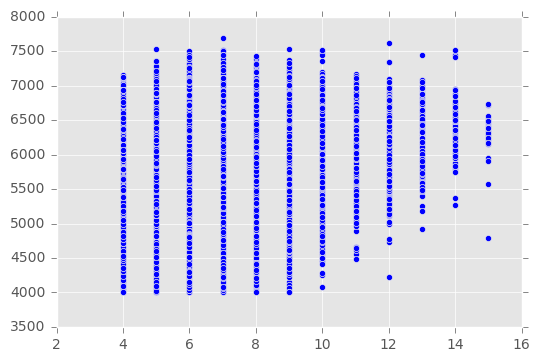

In [131]:
width = []
ene = []
for pmap in pmaps[selection]:
    s2 = pmap.get("S2")[0]
    width.append(s2.width)
    ene.append(s2.cathode_integral)
    
plt.scatter(width, ene)

In [122]:
plt.hist([pmap.get("S2")[0].peakmax[0] for pmap in pmaps], 100)

IndexError: list index out of range

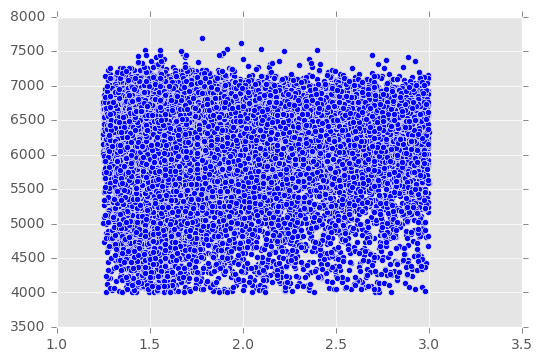

In [132]:
maxs1 = []
ene = []
for pmap in pmaps[selection]:
    s1s = pmap.get("S1")
    s2 = pmap.get("S2")[0]
    maxs1.append(max(peak.cathode_integral for peak in s1s))
    ene.append(s2.cathode_integral)
    
plt.scatter(maxs1, ene)
#plt.xlim((0.,1.))

In [133]:
for pmap in pmaps[selection]:
    s1max=0.
    for peak in pmap.get("S1"):
        if peak.cathode_integral>s1max:
            pmap.t0 = peak.cathode_integral
            s1max = peak.cathode_integral
    s2 = pmap.get("S2")[0]
    s2.z = s2.peakmax[0] - pmap.t0
    pmap.z = s2.z
    pmap.e = s2.cathode_integral

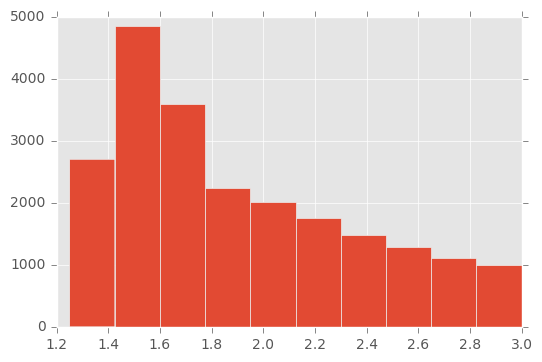

In [136]:
h = plt.hist([pmap.t0 for pmap in pmaps[selection]])

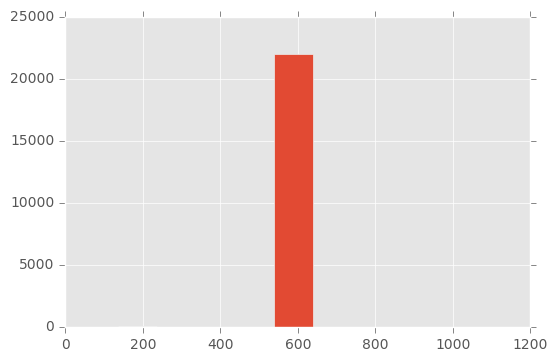

In [137]:
h = plt.hist([pmap.get("S2")[0].peakmax[0] for pmap in pmaps[selection]])

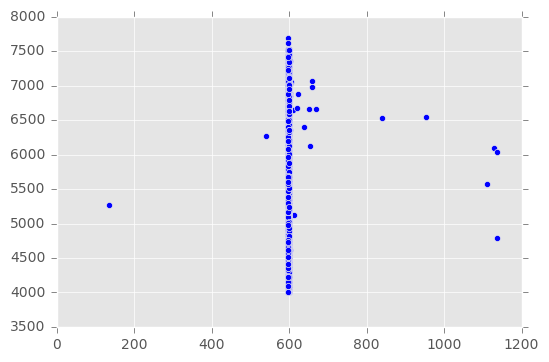

In [135]:
z, e = map(np.array, zip(*[(pmap.z, pmap.e) for pmap in pmaps[selection]]))
plt.scatter(z, e)

In [147]:
def baricenter(peak, sipmdf, thrs=0.25):
    q = np.nansum(peak.anode, axis=0)
    selection = q > np.max(q) * thrs
    q = q[selection]
    if not q.sum():
        return 0., 0.
    x = np.average(sipmdf["X"].values[selection], weights=q)
    y = np.average(sipmdf["Y"].values[selection], weights=q)
    return x, y


def get_xye(peak, sipmdf, thrs=0.2, att_corr=1.):
    x, y = baricenter(peak, sipmdf, thrs)
    return x, y, peak.cathode_integral * att_corr

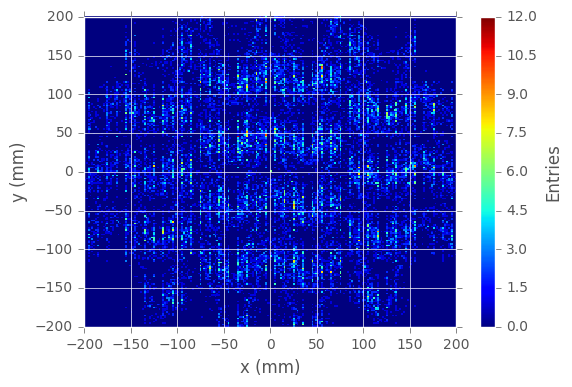

In [150]:
x, y = [], []
for pmap in pmaps[selection]:
    xb, yb = baricenter(pmap.get("S2")[0], sipmdf)
    x.append(xb)
    y.append(yb)

h = plt.hist2d(x, y, 200, range=((-200., 200.), (-200., 200.)))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar().set_label("Entries")

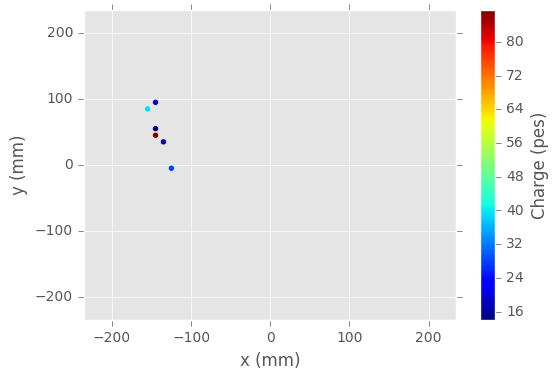

In [146]:
mpl.plot_anode_sum(pmaps[selection][6], sipmdf)

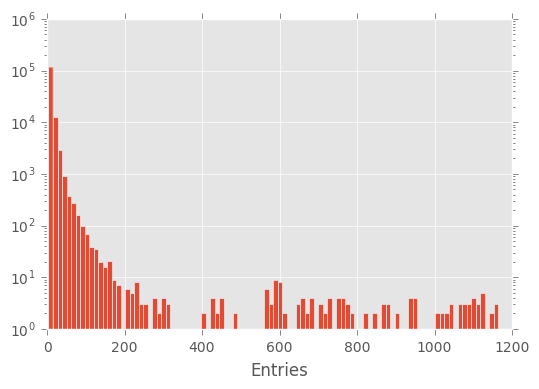

In [38]:
plt.figure()
h = plt.hist([peak.width for pmap in pmaps for peak in pmap.get("S2") if len(pmap.get("S2"))==1], 100)
plt.xlabel("S2 integral (pes)")
plt.xlabel("Entries")
plt.yscale("log")

In [49]:
for i, pmap in enumerate(pmaps):
    if len(pmap.get("S2"))==1 and 0 <= pmap.get("S2")[0].width<41:
        print(i)

49
962
4970
5633
5895
6433
7407
10890
10997
14741
19469
19724
24082
25104
29752
29830
30063
41561
47069
47937
48224
49429
49724
54054
54332
56471
56836
58277
59109
59159
60972
62006
64304
64991
65986
68366
68503
68727
69673
69751
69877
70890
72220
74488
74735
75975
76176
78495
87297
88189
88650
88978
89972
91849
94196
97854
100867
101313
105779
107420
112905
113869
115001
116210
116627
118014
118996
119764
122188
123835
124740
126113
126417
126566
127148
127194
127964
128979
133116
135480
135857
136649
144748
144929
145070
147434
148204
151935
151960
153442
154974
155771
159458
162921
164374
164383
164672
168108
168865
169524
170513
173485
173521
177349
178297
180144
180532
180947
182868
183281
183793
184504
187299


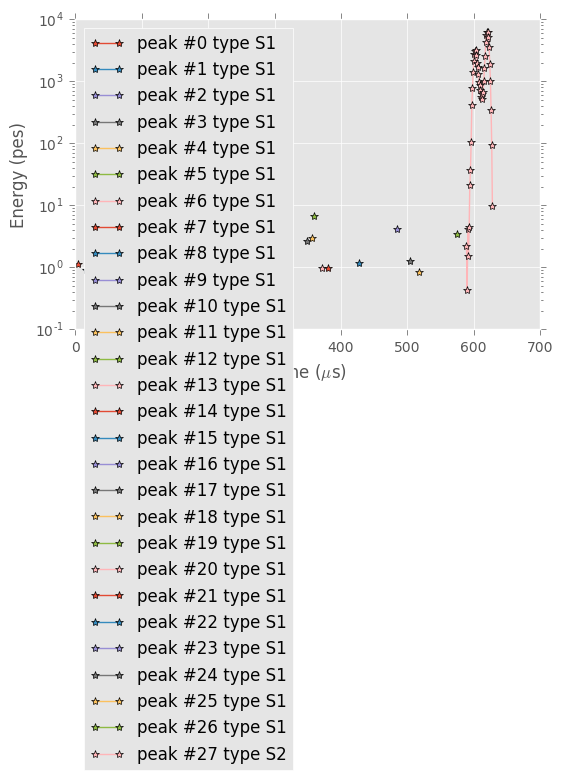

In [50]:
mpl.plot_pmap(pmaps[49])
plt.yscale("log")

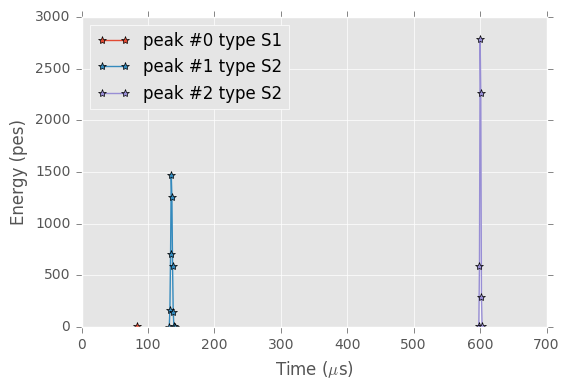

evt 0 max S1 4.39266729355


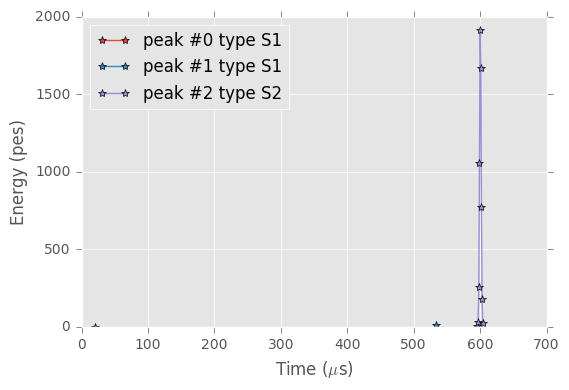

evt 1 max S1 11.2503852844


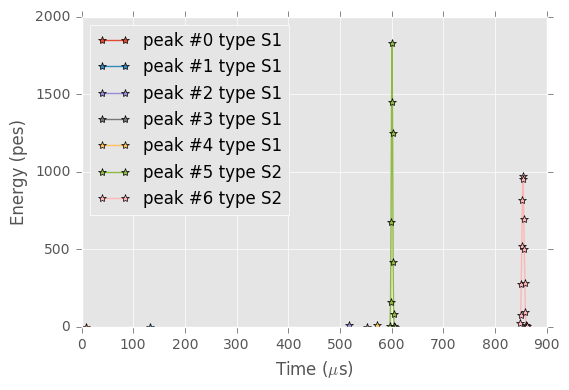

evt 2 max S1 13.21367836


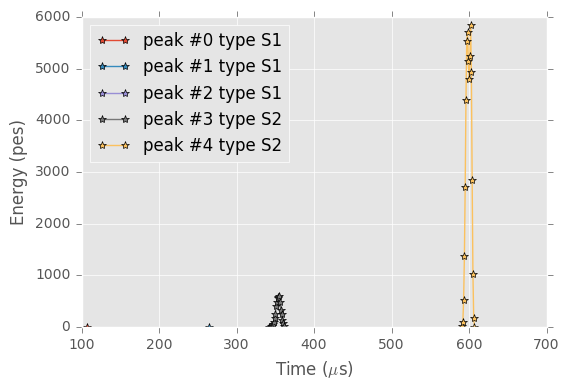

evt 3 max S1 1.43921625614


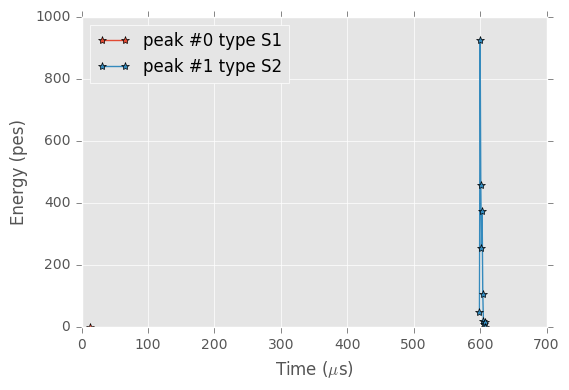

evt 4 max S1 0.941597998142


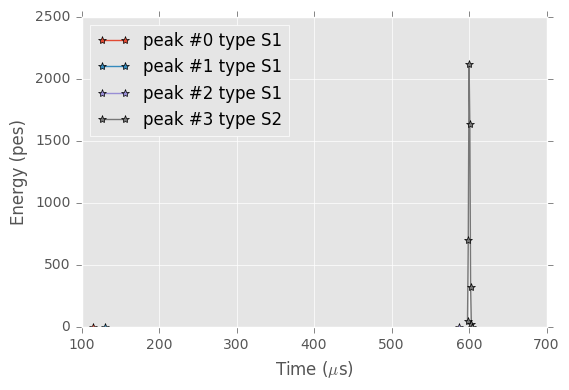

evt 5 max S1 1.96960222721


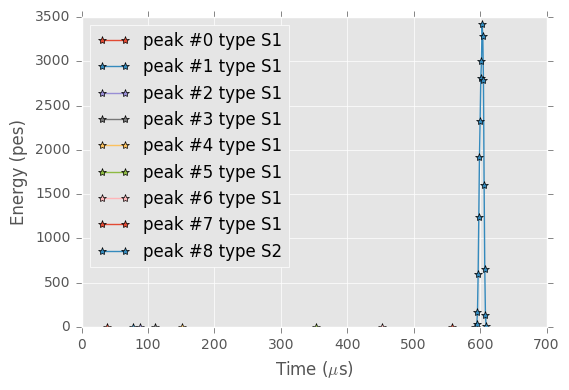

evt 6 max S1 4.60849475861


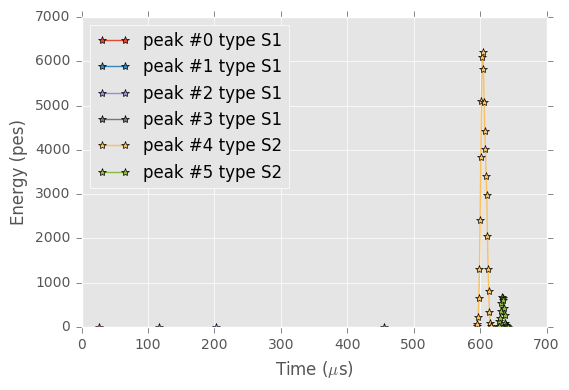

evt 7 max S1 1.5338588953


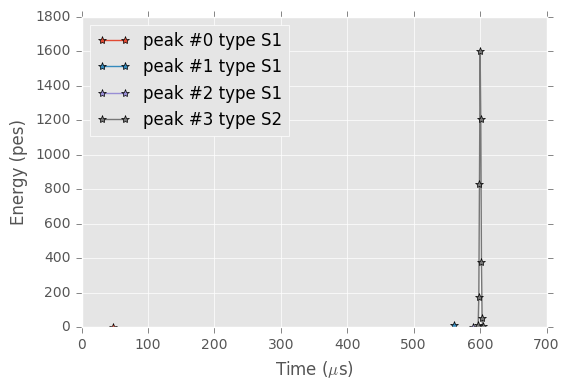

evt 8 max S1 11.3755645752


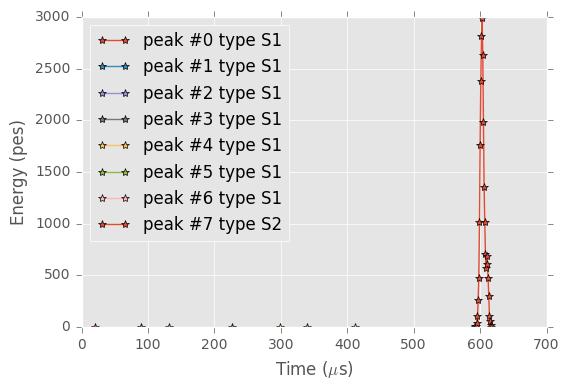

evt 9 max S1 1.44190311432


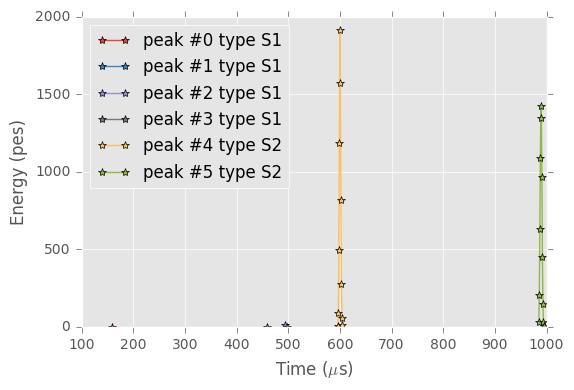

evt 10 max S1 12.6614904404


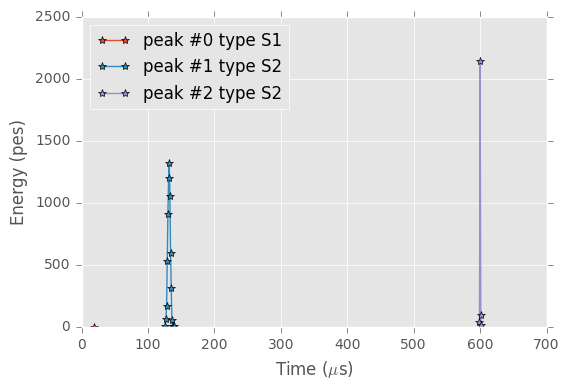

KeyboardInterrupt: 

In [31]:
for i in range(100):
    if not pmaps[i].get("S1"): continue
    pmap = pmaps[i]
    mpl.plot_pmap(pmap)
    plt.show()
    raw_input("evt {} max S1 {}".format(i, max(peak.cathode_integral for peak in pmap.get("S1"))))
    

In [50]:
evt = 10
mpl.plot_pmap(pmaps[evt], False)
plt.yscale("log")

IndexError: list index out of range

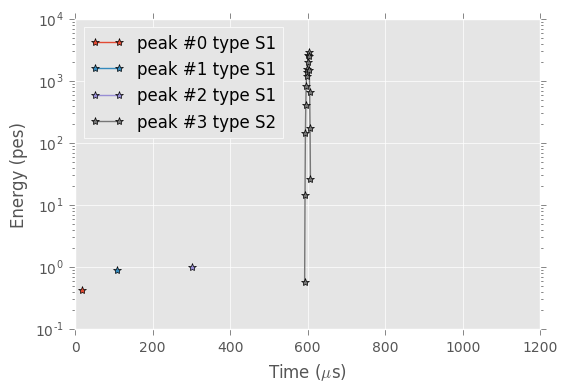

In [51]:
mpl.plot_pmap(pmaps2[evt], True)
plt.xlim((0,1200))
plt.yscale("log")

In [20]:
len(filter(lambda pmap: len(pmap.get("S1"))>=1 and len(pmap.get("S2"))==1, pmaps2))

70

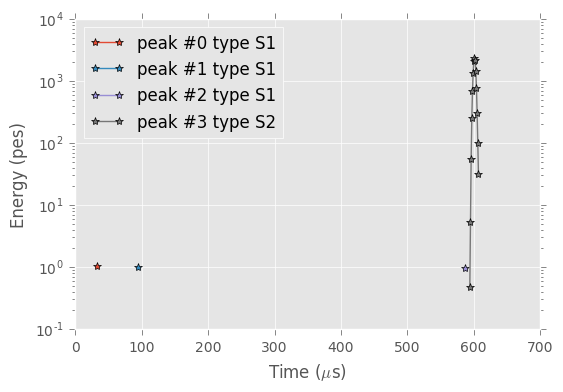

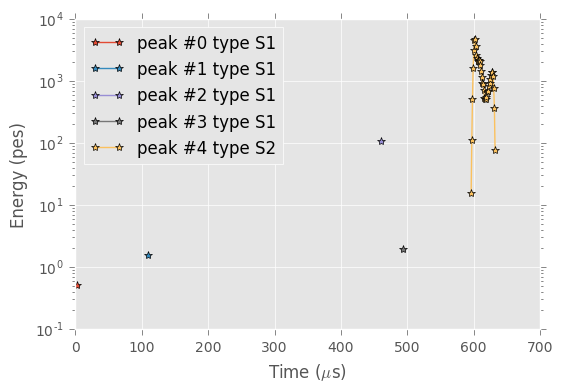

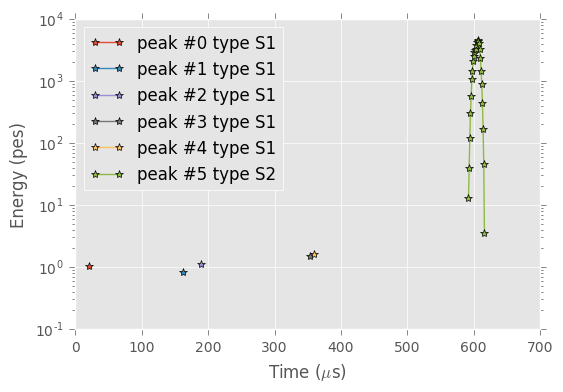

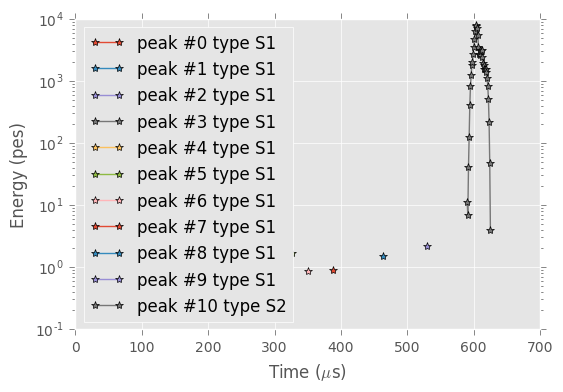

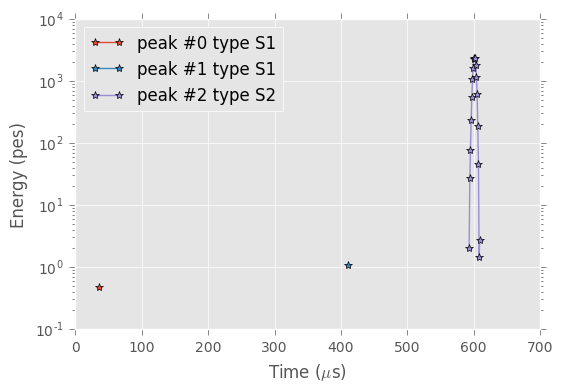

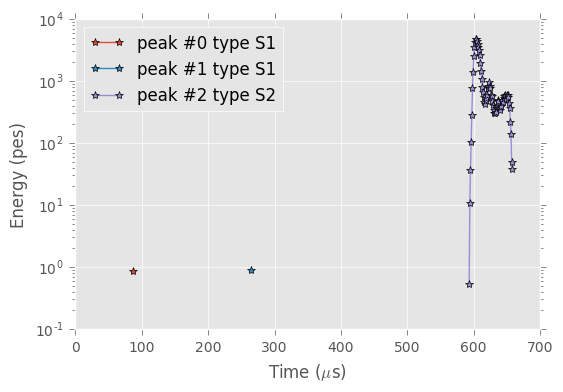

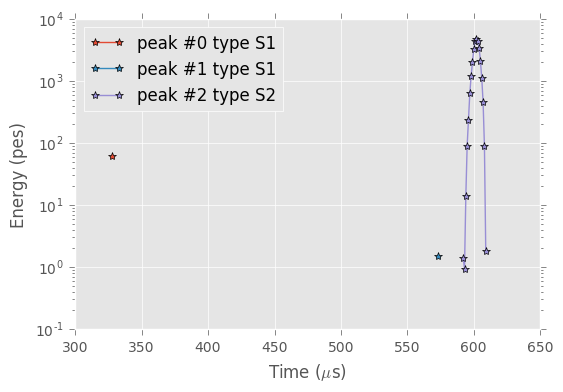

KeyboardInterrupt: 

In [21]:
for pmap in pmaps2:
    if not(len(pmap.get("S1"))>=1 and len(pmap.get("S2"))==1):
        continue
        
    mpl.plot_pmap(pmap)
    plt.yscale("log")
    plt.show()
    raw_input()

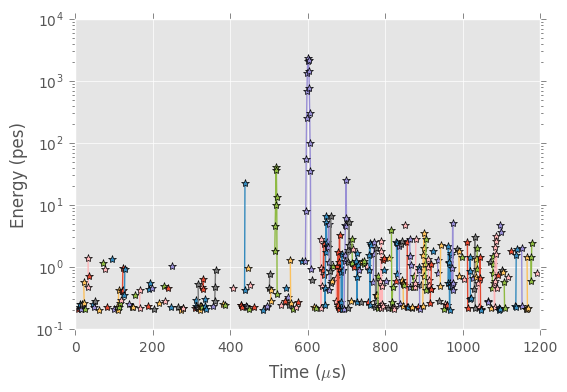

In [26]:
mpl.plot_pmap(pmaps[0], False)
plt.yscale("log")

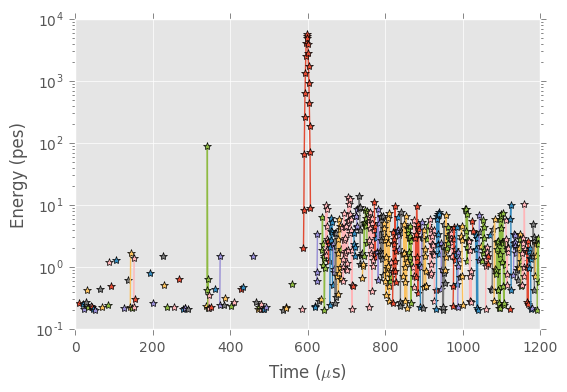

In [23]:
mpl.plot_pmap(pmap, False)
plt.yscale("log")

In [17]:
folder = "/Users/Gonzalo/github/IC/data/DATA/run_2978/"
filenames = os.listdir(folder)
pmaps = []
for ifile, filename in enumerate(filenames[:1]):
    print("File {} of {}".format(ifile, len(filenames)))
    with tb.open_file(folder+filename) as h5f:
        pmaptbl = h5f.root.PMAPS.PMaps
        pmaps_ = [tbl.read_pmap(pmaptbl, ievt) for ievt in range(tbl.get_nofevents(pmaptbl, "event"))]
        pmaps.extend(pmaps_)

File 0 of 596


KeyboardInterrupt: 

In [40]:
h5data = tb.open_file('/Users/Gonzalo/github/IC/data/DATA/run_2948_2_RWF.h5')

In [10]:
adc_to_pes = abs(1.0/DB.DataPMT()["adc_to_pes"].reshape(12, 1))
sipmdf = DB.DataSiPM()

In [41]:
def sum_zs(wf):
    return np.sum(wf[wf>1.])

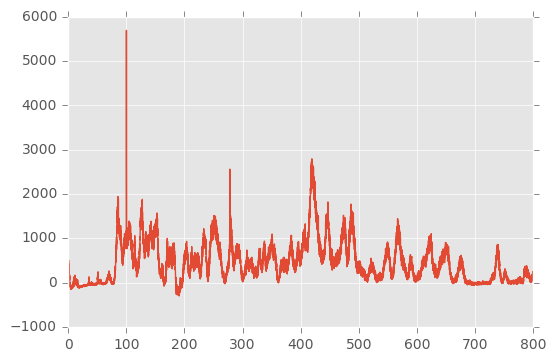

In [59]:
plt.plot(np.arange(32000.)/40., h5data.root.RD.pmtcwf[:100,0,:].sum(axis=0))

In [ ]:
h = plt.hist([sum_zs(wf*adc_to_pes) for wf in h5data.root.RD.pmtcwf], 200, range=(0,4e5))
plt.yscale("log")

In [5]:
def baricenter(peak, sipmdf, thrs=0.25):
    q = np.nansum(peak.anode, axis=0)
    selection = q > np.max(q) * thrs
    q = q[selection]
    if not q.sum():
        return 0., 0.
    x = np.average(sipmdf["X"].values[selection], weights=q)
    y = np.average(sipmdf["Y"].values[selection], weights=q)
    return x, y


def get_xye(peak, sipmdf, thrs=0.2, att_corr=1.):
    x, y = baricenter(peak, sipmdf, thrs)
    return x, y, peak.cathode_integral * att_corr

In [63]:
def XRselector(pmap):
    s1s = pmap.get("S1")
    if not len(s1s) or not any(abs(s1.peakmax[0]-100.)<2. for s1 in s1s):
        return False
    s2s = pmap.get("S2")
    if len(s2s) <= 1:
        return False
    return True
#    return 0 < s2s[0].cathode_integral < 125000

def isXR(peak):
    return 3500 < peak.cathode_integral < 6500

In [68]:
XR = filter(XRselector, pmaps)
print("{:.2f}% = {} pmaps".format(len(XR)*100./len(pmaps), len(XR)))

5.47% = 722 pmaps


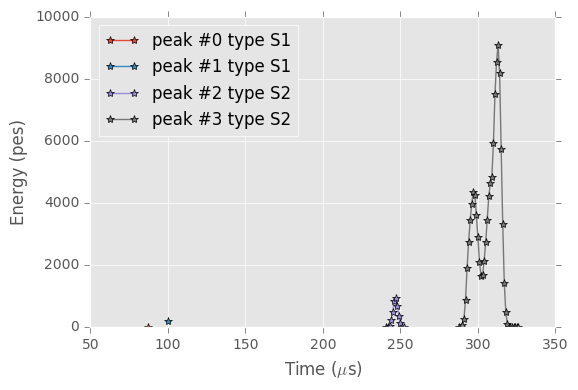

In [66]:
mpl.plot_pmap(XR[1])

In [8]:
def plot_anode(data, full_evt=True, show_baricenter=True):
    if full_evt:
        sipms_integral = np.nansum(np.concatenate([peak.anode for peak in data], axis=0), axis=0)
    else:
        sipms_integral = np.nansum(data.anode, axis=0)
    fig = plt.figure()
    xmin, xmax = np.nanmin(sipmdf["X"].values), np.nanmax(sipmdf["X"].values)
    ymin, ymax = np.nanmin(sipmdf["Y"].values), np.nanmax(sipmdf["Y"].values)
    selection = sipms_integral > np.nanmax(sipms_integral) * 0.1
    x, y, z = sipmdf["X"][selection], sipmdf["Y"][selection], sipms_integral[selection]
    scplot = plt.scatter(x, y, c=z)
    if show_baricenter and not full_evt:
        xb, yb = baricenter(data, sipmdf)
        plt.plot([xb], [yb], "r*")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))
    plt.tight_layout()
    fig.colorbar(scplot, ax=plt.gca()).set_label("Charge (pes)")


def plot_slice(slice_):
    sipms_integral = slice_
    fig = plt.figure()
    xmin, xmax = np.nanmin(sipmdf["X"].values), np.nanmax(sipmdf["X"].values)
    ymin, ymax = np.nanmin(sipmdf["Y"].values), np.nanmax(sipmdf["Y"].values)
    selection = sipms_integral > np.nanmax(sipms_integral) * 0.1
    x, y, z = sipmdf["X"][selection], sipmdf["Y"][selection], sipms_integral[selection]
    scplot = plt.scatter(x, y, c=z)
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))
    plt.tight_layout()
    fig.colorbar(scplot, ax=plt.gca()).set_label("Charge (pes)")


def plot_q_order(peak):
    qs = np.fliplr(np.sort(np.nansum(peak.anode, axis=0)))
    plt.plot(qs)

    
from matplotlib import animation, rc
from IPython.display import HTML


def make_movie(pmap):
    rc('animation', html='html5')
#    matplotlib.rcParams['animation.writer'] = 'avconv'
    fig, ax = plt.subplots()
    xmin, xmax = np.nanmin(sipmdf["X"].values), np.nanmax(sipmdf["X"].values)
    ymin, ymax = np.nanmin(sipmdf["Y"].values), np.nanmax(sipmdf["Y"].values)
    ax.set_xlabel("x (mm)")
    ax.set_ylabel("y (mm)")
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    scplot = ax.scatter([], [], c=[])
    slices = [slice_ for peak in pmap for slice_ in peak.anode]
    cbar = fig.colorbar(scplot, ax=ax, vmin=0, vmax=np.max(slices))
    cbar.set_label("Charge (pes)")
    def init():
#        scplot.set_data([], [], c=[])
        return (scplot,)
    def animate(i):
        sipms_integral = slices[i]
        selection = sipms_integral > np.nanmax(sipms_integral) * 0.1
        x, y = sipmdf["X"][selection].values, sipmdf["Y"][selection].values
        z = sipms_integral[selection]
        scplot.set_offsets([x, y])
        scplot.set_array(z)
        cbar.update_bruteforce(scplot)
        return (scplot,)
    
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(slices), interval=200, blit=False)
#    HTML(anim.to_html5_video())
    return anim
    

def make_movie(pmap):
    rc('animation', html='html5')
#    matplotlib.rcParams['animation.writer'] = 'avconv'
    fig, ax = plt.subplots()
    cbar = 0
    slices = [slice_ for peak in pmap for slice_ in peak.anode]
    def init():
        global cbar, scplot
        xmin, xmax = np.nanmin(sipmdf["X"].values), np.nanmax(sipmdf["X"].values)
        ymin, ymax = np.nanmin(sipmdf["Y"].values), np.nanmax(sipmdf["Y"].values)
        ax.set_xlabel("x (mm)")
        ax.set_ylabel("y (mm)")
        ax.set_xlim((xmin, xmax))
        ax.set_ylim((ymin, ymax))
        scplot = ax.scatter([], [], c=[])
        slices = [slice_ for peak in pmap for slice_ in peak.anode]
        cbar = fig.colorbar(scplot, ax=ax)
        cbar.set_label("Charge (pes)")
        return (scplot,)
    def animate(i):
        global cbar, scplot
        sipms_integral = slices[i]
        selection = sipms_integral > np.nanmax(sipms_integral) * 0.1
        x, y = sipmdf["X"][selection].values, sipmdf["Y"][selection].values
        z = sipms_integral[selection]
        xmin, xmax = np.nanmin(sipmdf["X"].values), np.nanmax(sipmdf["X"].values)
        ymin, ymax = np.nanmin(sipmdf["Y"].values), np.nanmax(sipmdf["Y"].values)
        cbar.remove()
        fig.clear()
#        scplot.set_offsets([x,y])
#        scplot.set_array(z)
        ax = plt.gca()
        ax.set_xlabel("x (mm)")
        ax.set_ylabel("y (mm)")
        ax.set_xlim((xmin, xmax))
        ax.set_ylim((ymin, ymax))
        scplot = ax.scatter(x, y, c=z)
        cbar = fig.colorbar(scplot, ax=ax)
        cbar.set_label("Charge (pes)")
        return (scplot,)
    
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(slices), interval=200, blit=False)
#    HTML(anim.to_html5_video())
    return anim
    


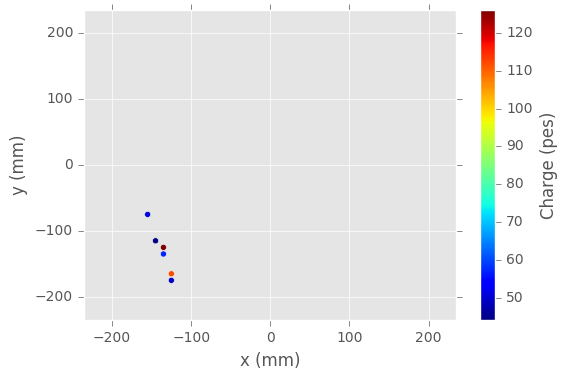

In [42]:
mpl.plot_anode_sum(pmaps2[0], sipmdf, 0.3)

# Energy spectrum (full & XR w/o fiducialization)

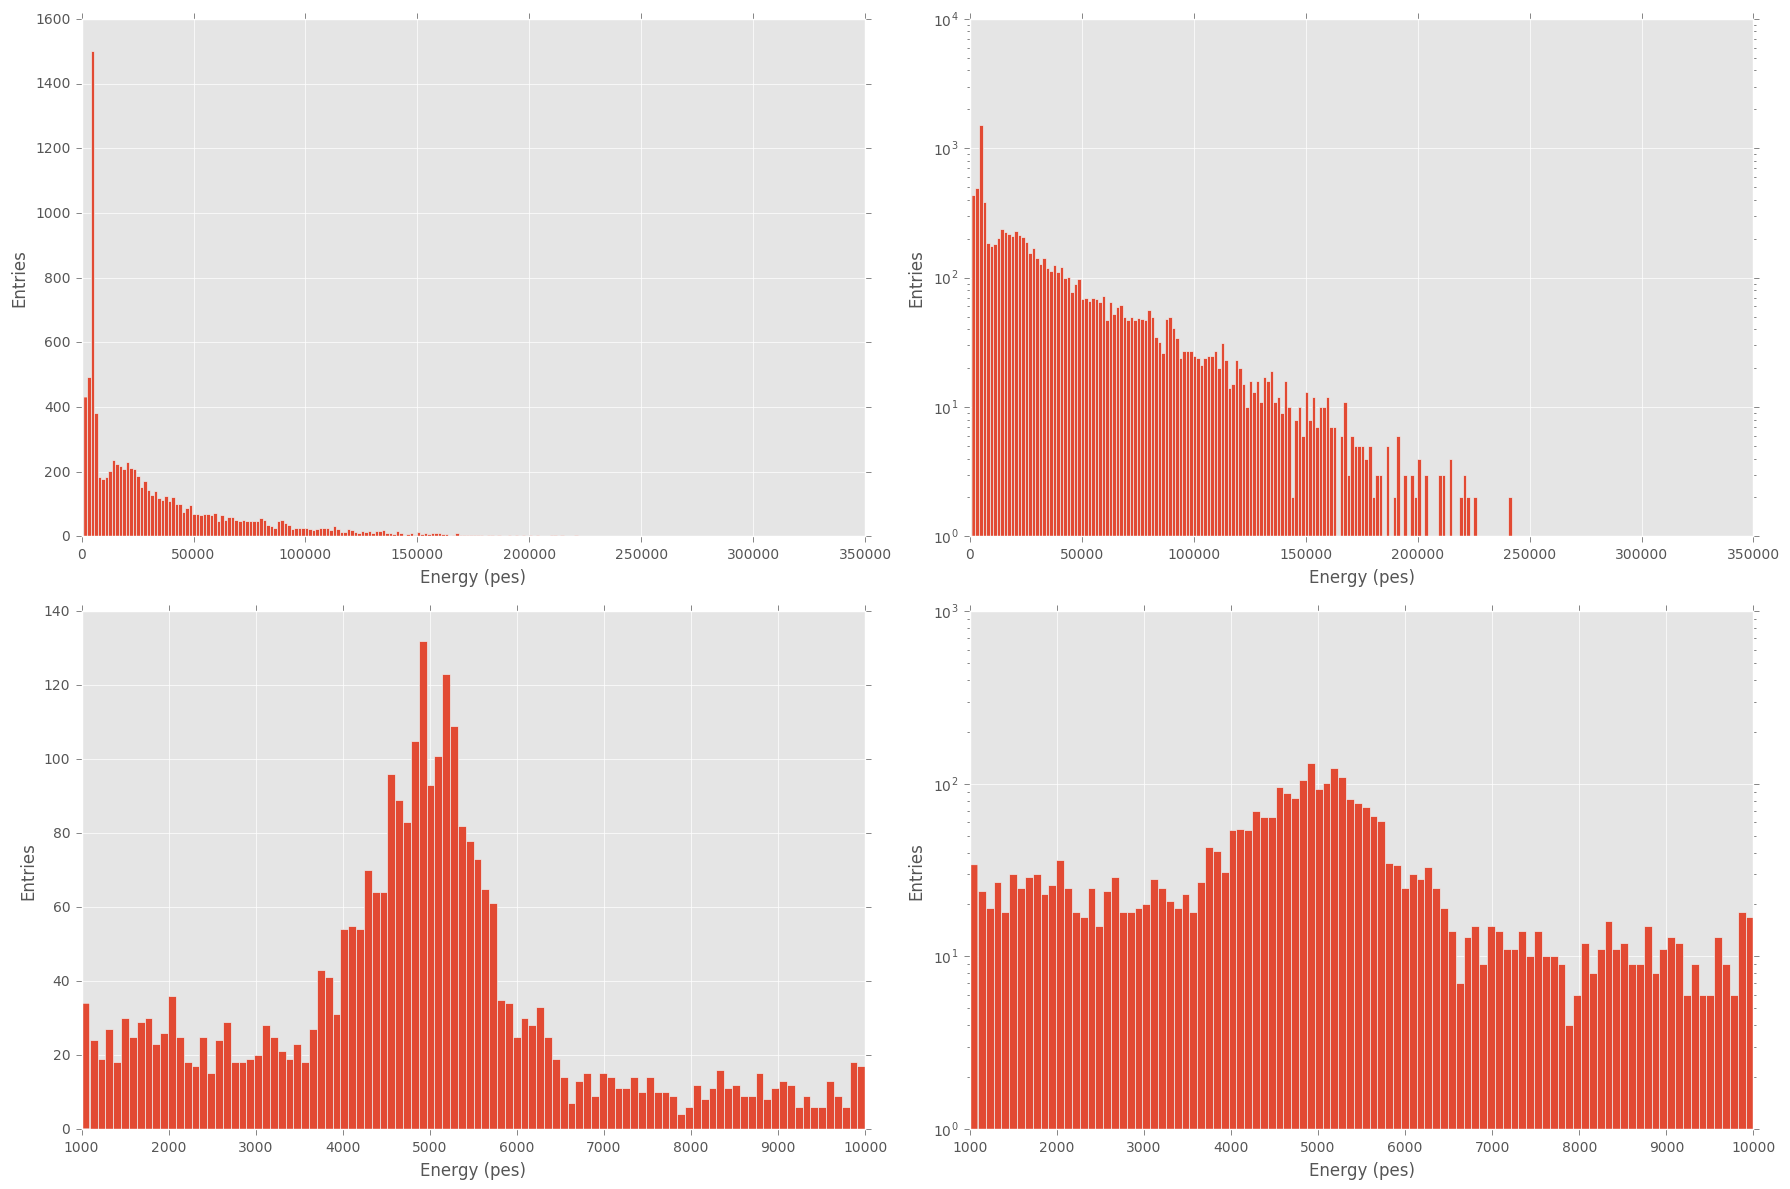

In [10]:
fig, axes = plt.subplots(2,2)
fig.set_size_inches(18,12)
E = np.array([peak.cathode_integral for pmap in XR for peak in pmap])
E = E[E>500]
h = axes[0,0].hist(E, 200)
h = axes[0,1].hist(E, 200)

E = E[E<1e4]
h = axes[1,0].hist(E, 100)
h = axes[1,1].hist(E, 100)

for ax in axes.flatten():
    ax.set_xlabel("Energy (pes)")
    ax.set_ylabel("Entries")

axes[0,1].set_yscale("log")
axes[1,1].set_yscale("log")
plt.tight_layout()

# Energy spectrum (full & XR with 10 cm fiducialization)

In [11]:
def in_fiducial(peak, sipmdf, rmax=100.):
    x, y = baricenter(peak, sipmdf)
    return x**2 + x**2 < rmax**2

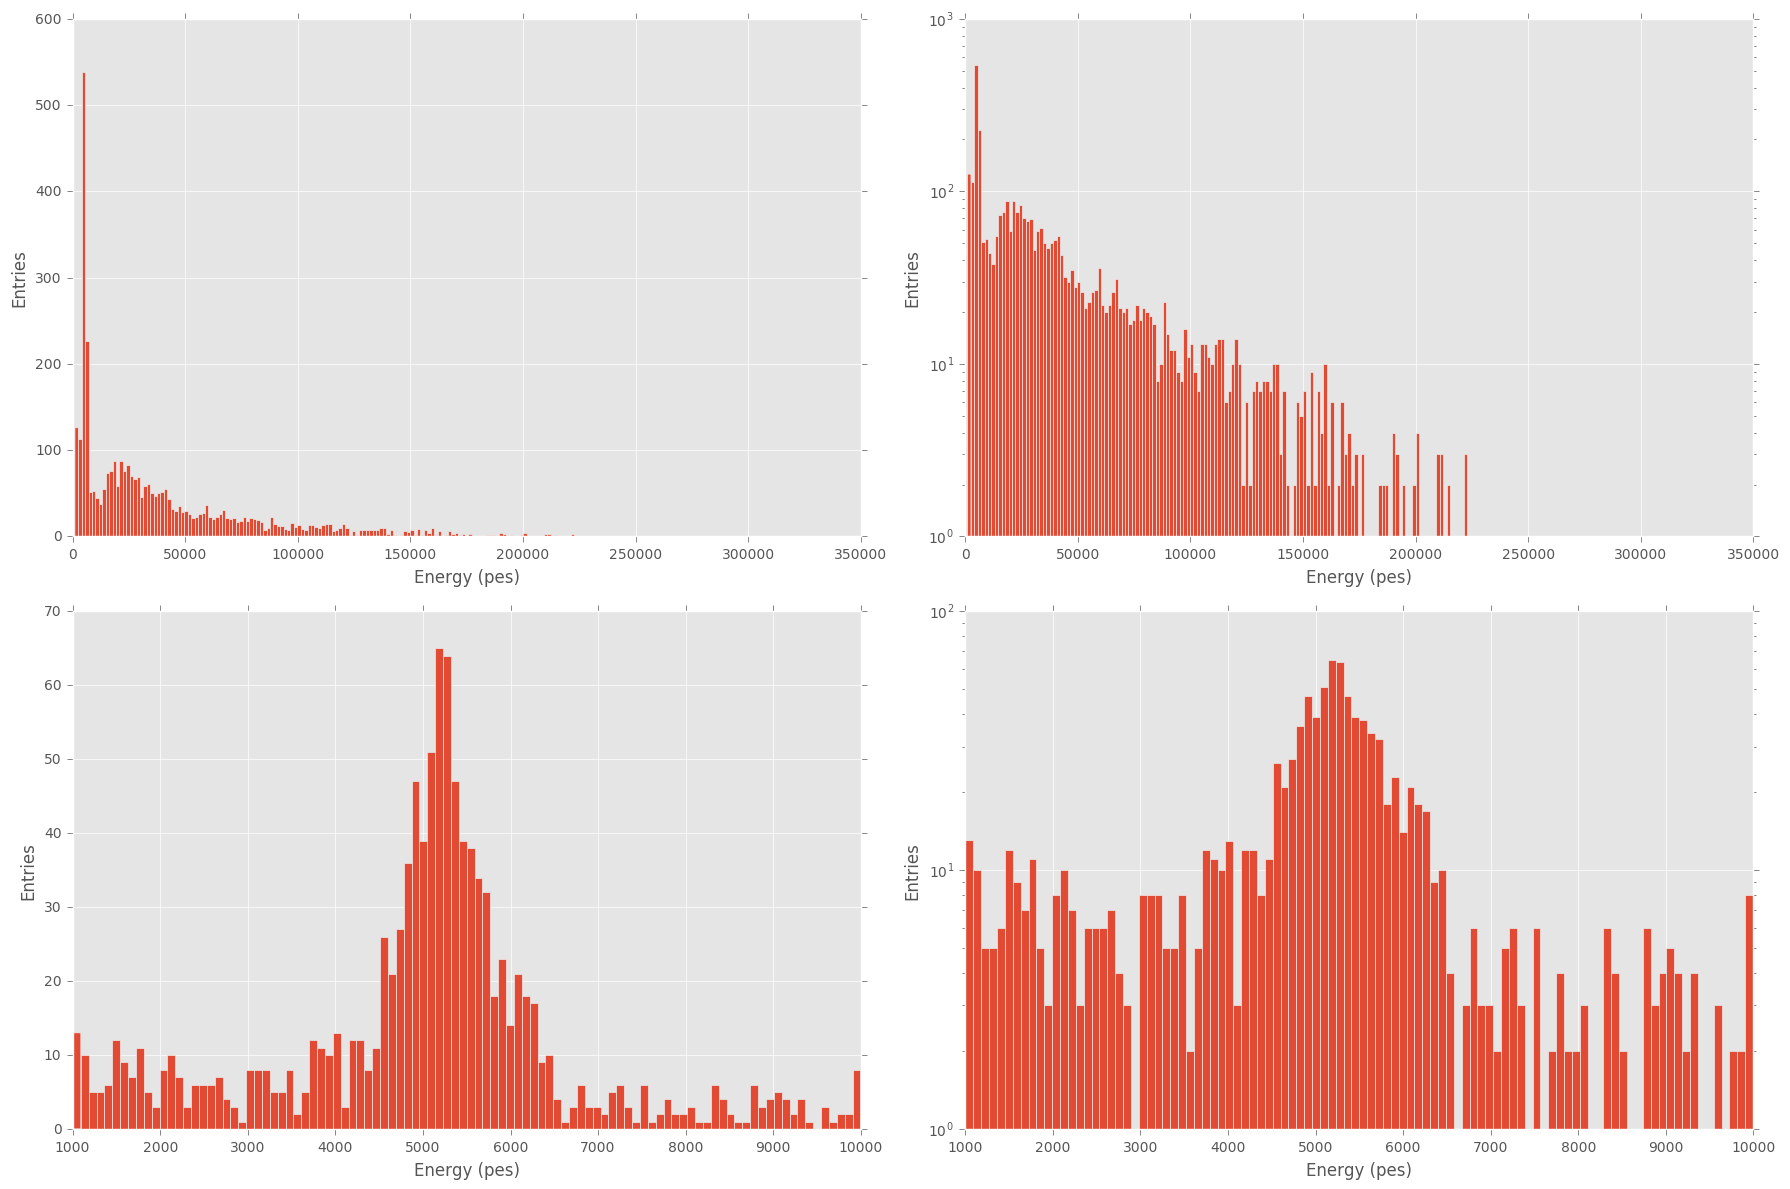

In [12]:
fig, axes = plt.subplots(2,2)
fig.set_size_inches(18,12)
E = np.array([peak.cathode_integral for pmap in XR for peak in pmap if in_fiducial(peak, sipmdf)])
E = E[E>500]
h = axes[0,0].hist(E, 200)
h = axes[0,1].hist(E, 200)

E = E[E<1e4]
h = axes[1,0].hist(E, 100)
h = axes[1,1].hist(E, 100)

for ax in axes.flatten():
    ax.set_xlabel("Energy (pes)")
    ax.set_ylabel("Entries")

axes[0,1].set_yscale("log")
axes[1,1].set_yscale("log")
plt.tight_layout()

# Fit to XR peak (w/o fidufialization)

1.3e+05 +- 5e+03
5e+03 +- 20
5.7e+02 +- 22
1.7e+03 +- 1.8e+03
6.3e+03 +- 1.1e+02
1e+02 +- 1.1e+02
33 +- 2.7
-7.2e+03 +- 1e+03
Resolution = 26.8950598674 @ 30 keV
Resolution = 2.9712705842 @ Qbb


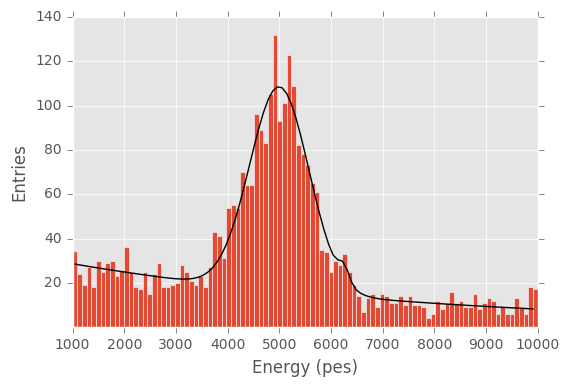

In [13]:
E = np.array([peak.cathode_integral for pmap in XR for peak in pmap])
E = E[(E>500) & (E<1e4)]

h = plt.hist(E, 100)

x = h[1][:-1]
y = h[0]
#g, v, e = fit.fit("gauss + expo", x, y, (2e5, 4900., 400., 50., -2e+4))
g, v, e = fit.fit("gauss + gauss + expo", x, y, (2e5, 5200., 400., 1e2, 6300., 500., 10., -1e4),
                  bounds=[(1e4, 5000., 200., 1e1, 6000, 100.,1e-1,-2e4),
                          (3e6, 5500., 600., 5e4, 6800, 800., 50., -5e3)])

plt.plot(x, g(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
print("\n".join(["{:.2g} +- {:.2g}".format(vi, ei) for vi, ei in zip(v, e)]))
print("Resolution = {} @ 30 keV".format(235.*v[2]/v[1]))
print("Resolution = {} @ Qbb".format(235.*v[2]/v[1]*(30./2458.)**0.5))

plt.ylim((1e-1, plt.ylim()[1]))
pass

# Fit to XR peak (with 10 cm fidufialization)

5.02e+04 +- 1.9e+03
5.17e+03 +- 15
395 +- 17
4.9e+03 +- 1.2e+03
6.12e+03 +- 41
164 +- 42
9.62 +- 1.3
-7.41e+03 +- 1.7e+03
Resolution = 17.9785085093 @ 30 keV
Resolution = 1.98620169447 @ Qbb


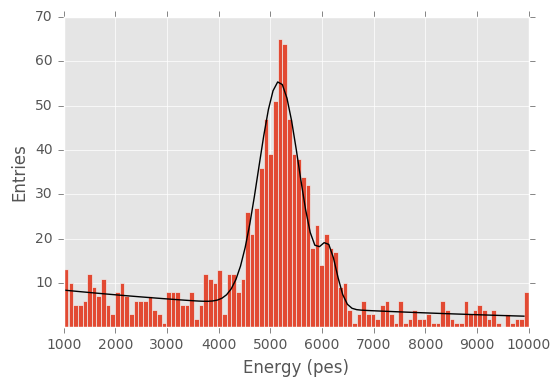

In [14]:
E = np.array([peak.cathode_integral for pmap in XR for peak in pmap if in_fiducial(peak, sipmdf)])
E = E[(E>500) & (E<1e4)]

h = plt.hist(E, 100)

x = h[1][:-1]
y = h[0]
#g, v, e = fit.fit("gauss + expo", x, y, (2e5, 4900., 400., 50., -2e+4))
g, v, e = fit.fit("gauss + gauss + expo", x, y, (2e5, 5200., 400., 1e2, 6300., 500., 10., -1e4),
                  bounds=[(1e4, 5000., 200., 1e1, 6000, 100.,1e-1,-2e4),
                          (3e6, 5500., 600., 5e4, 6800, 800., 50., -5e3)])

plt.plot(x, g(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
print("\n".join(["{:.3g} +- {:.2g}".format(vi, ei) for vi, ei in zip(v, e)]))
print("Resolution = {} @ 30 keV".format(235.*v[2]/v[1]))
print("Resolution = {} @ Qbb".format(235.*v[2]/v[1]*(30./2458.)**0.5))

plt.ylim((1e-1, plt.ylim()[1]))
pass

# Correction by attachment

5.04e+03 · exp(x/-1.96e+04)


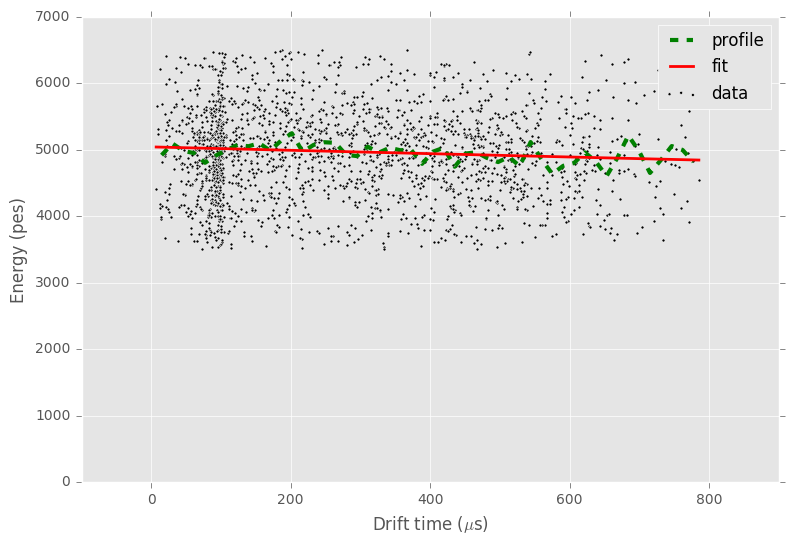

In [62]:
z = []
E = []
for pmap in XR:
    pmap.t0 = pmap.get("S1")[0].peakmax[0]
    for peak in pmap:
        peak.z = peak.peakmax[0] - pmap.t0
        if not isXR(peak):
            continue
        z.append(peak.z)
        E.append(peak.cathode_integral)

zp, Ep, Ep_err = mpl.profile(z, E, 50)
p = plt.scatter(z, E, marker=".", facecolors="k", label="data")
p = plt.plot(zp, Ep, "g--", linewidth=3, label="profile")

plt.ylim((0,7000))
f, v, e = fit.fit("expo", zp, Ep, (6000., -1e4))
print("{:.3g} · exp(x/{:.3g})".format(*v))
x = np.linspace(np.min(z), np.max(z), 100)
y = f(x)
plt.plot(x, y, "r-", linewidth=2, label="fit")
plt.xlabel("Drift time ($\mu$s)")
plt.ylabel("Energy (pes)")
plt.legend()
plt.gcf().set_size_inches(9,6)

att_func = copy.copy(f)

In [16]:
att_corr = lambda x: att_func(0.)/att_func(x)

5.05e+04 +- 1.9e+03
5.24e+03 +- 16
403 +- 18
5.13e+03 +- 1.4e+03
6.2e+03 +- 49
190 +- 49
9.52 +- 1.2
-7.17e+03 +- 1.6e+03
Resolution = 18.0776268196 @ 30 keV
Resolution = 1.99715193295 @ Qbb


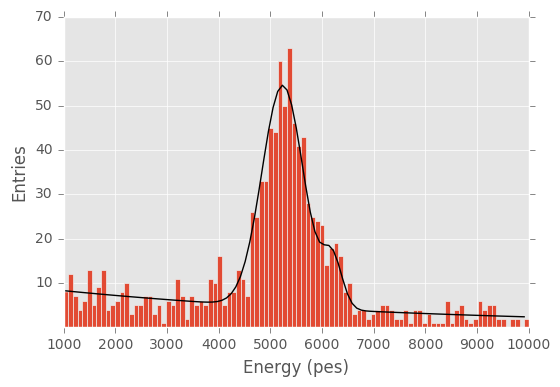

In [17]:
E = np.array([peak.cathode_integral * att_corr(peak.z) for pmap in XR for peak in pmap if in_fiducial(peak, sipmdf)])
E = E[(E>500) & (E<1e4)]

h = plt.hist(E, 100, range=(1e3, 1e4))

x = h[1][:-1]
y = h[0]
#g, v, e = fit.fit("gauss + expo", x, y, (2e5, 4900., 400., 50., -2e+4))
g, v, e = fit.fit("gauss + gauss + expo", x, y, (2e5, 5200., 400., 1e2, 6300., 500., 10., -1e4),
                  bounds=[(1e4, 5000., 200., 1e1, 6000, 100.,1e-1,-2e4),
                          (3e6, 5500., 600., 5e4, 6800, 800., 50., -5e3)])

plt.plot(x, g(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
print("\n".join(["{:.3g} +- {:.2g}".format(vi, ei) for vi, ei in zip(v, e)]))
print("Resolution = {} @ 30 keV".format(235.*v[2]/v[1]))
print("Resolution = {} @ Qbb".format(235.*v[2]/v[1]*(30./2458.)**0.5))

plt.ylim((1e-1, plt.ylim()[1]))
pass

# Geometrical corrections

5.5e+03 + -1.86x + -0.014x^2


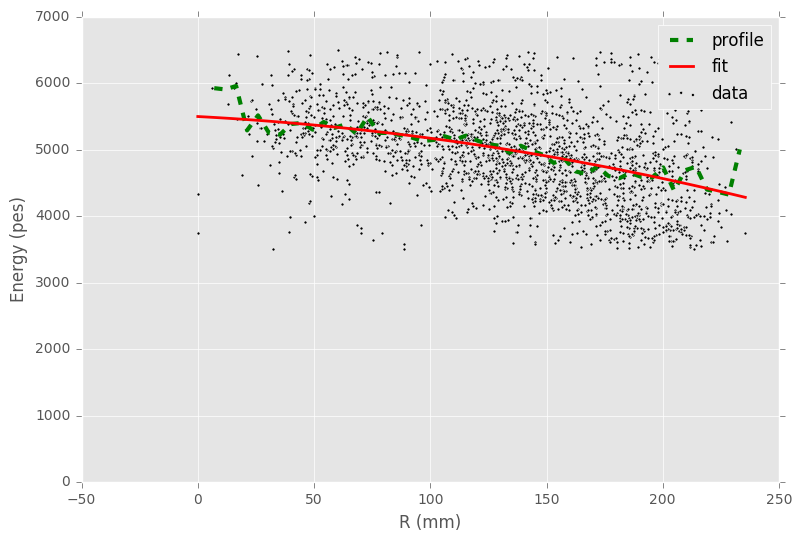

In [23]:
r = []
E = []
for pmap in XR:
    for peak in pmap:
        peak.x, peak.y = baricenter(peak, sipmdf)
        peak.r = (peak.x**2 + peak.y**2)**0.5
        if not isXR(peak):
            continue
        r.append(peak.r)
        E.append(peak.cathode_integral)

rp, Ep, Ep_err = mpl.profile(r, E, 50)
p = plt.scatter(r, E, marker=".", facecolors="k", label="data")
p = plt.plot(rp, Ep, "g--", linewidth=3, label="profile")

f, v, e = fit.fit("polynom", r, E, (6000., -1e-2, -1e-4))
print("{:.3g} + {:.3g}x + {:.3g}x^2".format(*v))
x = np.linspace(np.min(r), np.max(r), 100)
y = f(x)
plt.plot(x, y, "r-", linewidth=2, label="fit")
plt.ylim((0,7000))
plt.xlabel("R (mm)")
plt.ylabel("Energy (pes)")
plt.legend()
plt.gcf().set_size_inches(9,6)

geo_func = copy.copy(f)

In [24]:
geo_corr = lambda x: geo_func(0.)/geo_func(x)

5.45e+04 +- 1.7e+03
5.55e+03 +- 13
440 +- 15
3.66e+03 +- 9e+02
6.61e+03 +- 34
137 +- 35
7.35 +- 1
-9.28e+03 +- 2.6e+03
Resolution = 18.6309595083 @ 30 keV
Resolution = 2.05828216093 @ Qbb


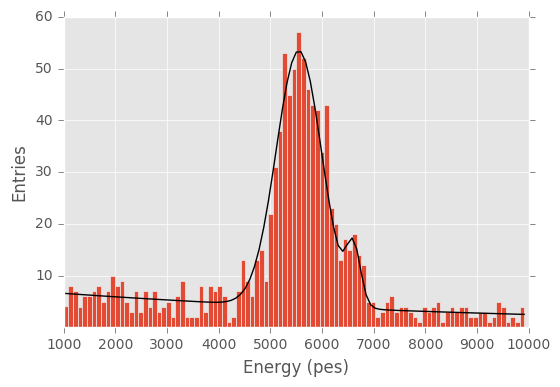

In [33]:
E = np.array([peak.cathode_integral * att_corr(peak.z) * geo_corr(peak.r) for pmap in XR for peak in pmap if in_fiducial(peak, sipmdf)])
E = E[(E>500) & (E<1e4)]

h = plt.hist(E, 100, range=(1e3, 1e4))

x = h[1][:-1]
y = h[0]
#g, v, e = fit.fit("gauss + expo", x, y, (2e5, 4900., 400., 50., -2e+4))
g, v, e = fit.fit("gauss + gauss + expo", x, y, (2e5, 5800., 350., 1e2, 6800., 500., 10., -1e4),
                  bounds=[(1e4, 5200., 200., 1e1, 6300, 100., 1.0,-2e4),
                          (3e6, 6000., 440., 5e4, 7000, 800., 50., -5e3)])

plt.plot(x, g(x), "k-")
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")
print("\n".join(["{:.3g} +- {:.2g}".format(vi, ei) for vi, ei in zip(v, e)]))
print("Resolution = {} @ 30 keV".format(235.*v[2]/v[1]))
print("Resolution = {} @ Qbb".format(235.*v[2]/v[1]*(30./2458.)**0.5))

plt.ylim((1e-1, plt.ylim()[1]))
pass

# Event distribution

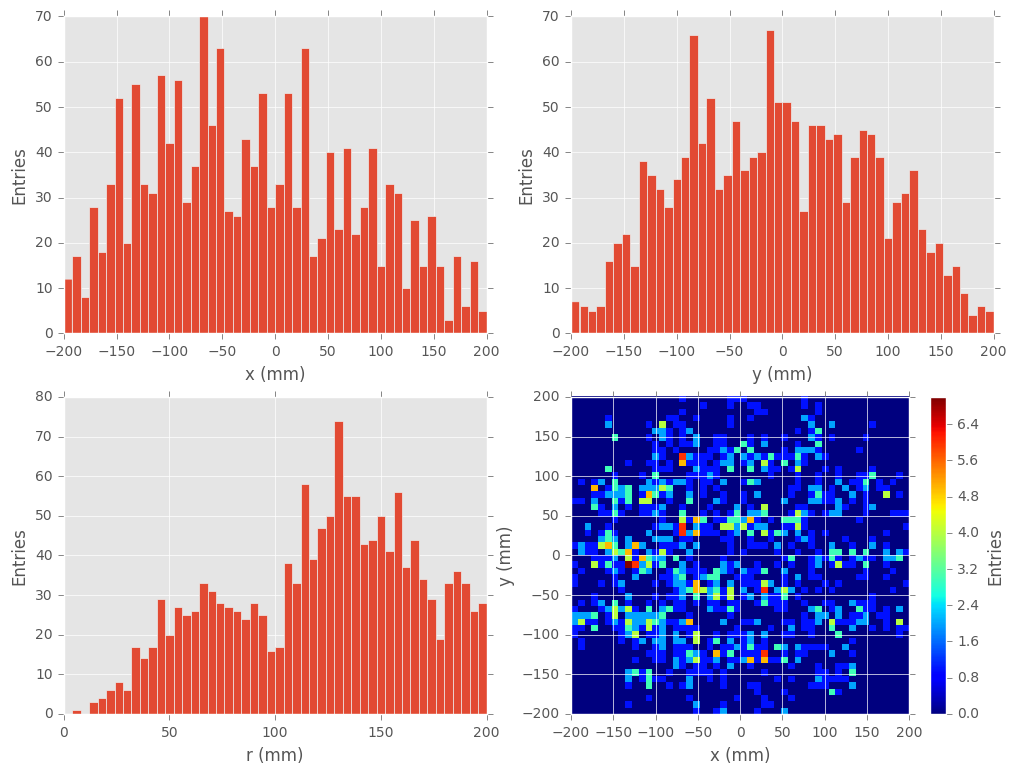

In [39]:
x, y, r, E = map(np.array, zip(*[(peak.x, peak.y, peak.r, peak.cathode_integral*att_corr(peak.z)*geo_corr(peak.r)) for pmap in XR for peak in pmap]))
selection = (E>5000) & (E<7000)
x, y, r, E = x[selection], y[selection], r[selection], E[selection]

plt.subplot(2,2,1)
h = plt.hist(x, 50, range=(-200., 200.))
plt.xlabel("x (mm)")
plt.ylabel("Entries")

plt.subplot(2,2,2)
h = plt.hist(y, 50, range=(-200., 200.))
plt.xlabel("y (mm)")
plt.ylabel("Entries")

plt.subplot(2,2,3)
h = plt.hist(r, 50, range=(0., 200.))
plt.xlabel("r (mm)")
plt.ylabel("Entries")

plt.subplot(2,2,4)
h = plt.hist2d(x, y, 50, range=((-200., 200.), (-200., 200.)))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.colorbar().set_label("Entries")

plt.gcf().set_size_inches(12, 9)

In [ ]:
plt.scatter()

In [71]:
pmap = tbl.read_pmap(pmaps_, 0)

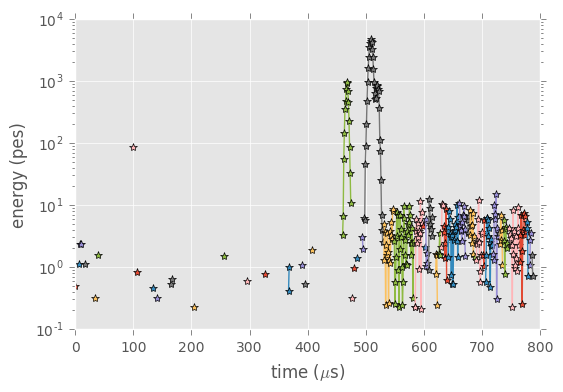

In [72]:
mpl.plot_pmap(pmap)
plt.yscale("log")

##### Reco functions

# XY event distribution

In [149]:
data = [get_xye(peak, sipmdf) for pmap in XR for peak in pmap if isXR(peak)]
#data = filter(lambda x: x[0] != 200. and x[1] != 200., data)
x, y, E = map(np.array, zip(*data))

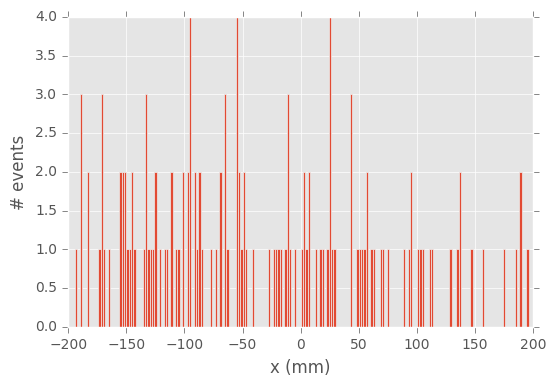

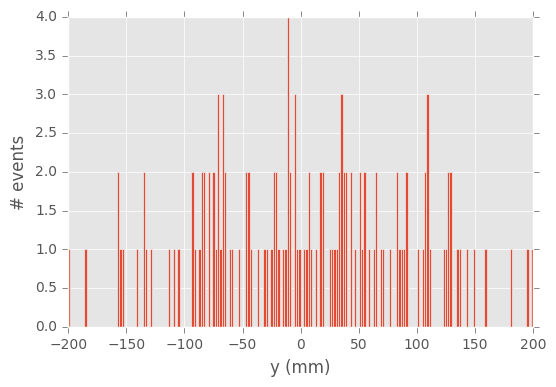

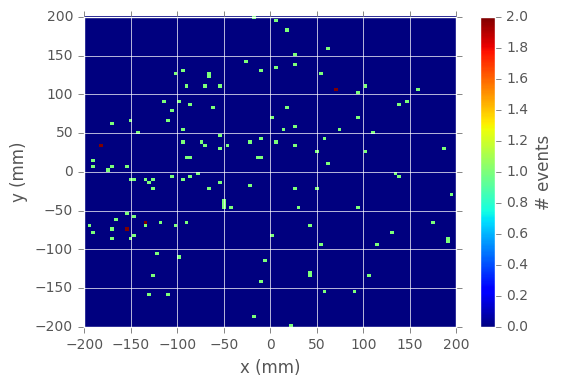

In [150]:
figx = plt.figure()
xh = plt.hist(x, 200, range=(-200,200))
plt.xlabel('x (mm)')
plt.ylabel('# events')
figy = plt.figure()
yh = plt.hist(y, 200, range=(-200,200))
plt.xlabel('y (mm)')
plt.ylabel('# events')
figxy = plt.figure()
xyh = plt.hist2d(x, y, 100, range=((-200,200),(-200,200)))
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar().set_label("# events")

[  5.40894856e+03  -3.52152575e+00   5.30486643e-03]


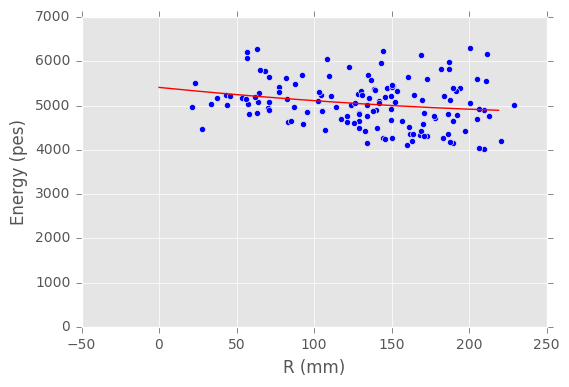

In [156]:
r = np.array([(xi**2 + yi**2)**0.5 for xi, yi in zip(x, y)])
plt.scatter(r, E)
plt.xlabel("R (mm)")
plt.ylabel("Energy (pes)")
plt.ylim((0,7000))
d = fit.fit_polynom(r, E, (6000., -1e-3, -1e-3))
xi = np.arange(0., 220.)
yi = fit.build_polynom(*d[0])(xi)
plt.plot(xi, yi, "r-")
print(d[0])

# SiPMs signal for some event

x, y, E = 200.0 200.0 0.0


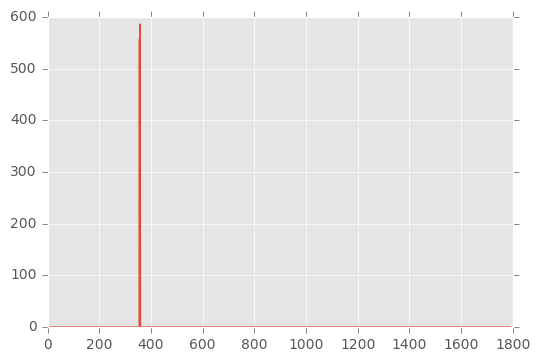

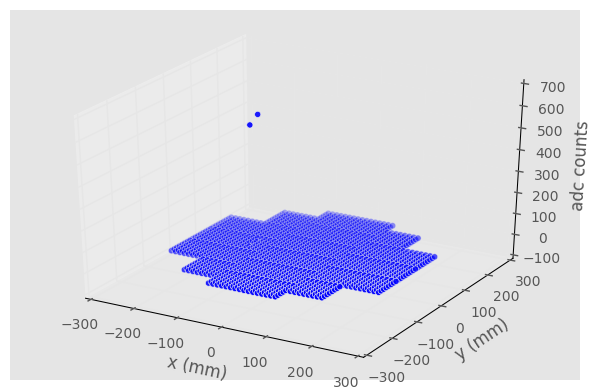

In [54]:
evt = 389
x, y, E = get_xye(pmtzswf[evt], sipmzswf[evt], sipmdf)
print("x, y, E =", x, y, E)
data = sipmzswf[evt].sum(axis=1)
data = wfm.suppress_wf(data, 0.8*np.max(data))
plt.plot(data)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sipmdf['x'], sipmdf['y'],data)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.set_zlabel("adc counts")
plt.tight_layout()